
# DEEP EUTECTIC SOLVENTS DENSITY. Data preparation and EDA


# 1. Reading data

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import re
import pubchempy as pcp
from rdkit import Chem
from scipy.stats import shapiro
from scipy.stats import jarque_bera


In [10]:
#Reading data
density_df = pd.read_csv('Density.csv')
density_df = density_df.round({'X#1 (molar fraction)': 3, 'X#2 (molar fraction)': 3, 'X#3 (molar fraction)': 3}) # Rounding of molar fractions
#Clearing data from abnormal density values
density_df = density_df.drop(np.where(density_df['Density, g/cm^3'] > 2)[0])
density_df.head(5)

,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI)
0,2,Ⅰ,1,0,0,0,0,Zincchloride,1-Butyl-3-methyl imidazolium chloride,NaN,0.500,0.500,NaN,300.20,1.10250,10.1016/j.cclet.2013.09.004
1,2,Ⅰ,1,0,0,0,0,Zincchloride,1-Butyl-3-methylimidazolium chloride,NaN,0.500,0.500,NaN,303.15,1.50913,10.1016/j.jobe.2021.103056
2,2,Ⅰ,1,0,0,0,0,Zincchloride,1-Butyl-3-methylimidazolium chloride,NaN,0.333,0.667,NaN,303.15,1.34292,10.1016/j.jobe.2021.103056
3,2,Ⅰ,1,0,0,0,0,Iron(3+) Trichloride,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,293.00,1.19500,10.1016/j.cep.2015.04.001
4,2,Ⅰ,1,0,0,0,0,Iron(3+) Trichloride,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,303.00,1.18800,10.1016/j.cep.2015.04.001


**A database containing 4500 rows was collected**

In [11]:
density_df.info() #Table Information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4302 entries, 0 to 4308
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Number of components  4302 non-null   int64  
 1   Type of DES           3977 non-null   object 
 2   I                     4302 non-null   int64  
 3   II                    4302 non-null   int64  
 4   III                   4302 non-null   int64  
 5   IV                    4302 non-null   int64  
 6   V                     4302 non-null   int64  
 7   Component#1           4302 non-null   object 
 8   Component#2           4302 non-null   object 
 9   Component#3           325 non-null    object 
 10  X#1 (molar fraction)  4302 non-null   float64
 11  X#2 (molar fraction)  4302 non-null   float64
 12  X#3 (molar fraction)  325 non-null    float64
 13  Temperature, K        4302 non-null   float64
 14  Density, g/cm^3       4302 non-null   float64
 15  Reference (DOI)      

In [12]:
density_df.describe() #Main characteristics of numeric columns

,Number of components,I,II,III,IV,V,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3"
count,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,325.000000,4302.000000,4302.000000
mean,2.075546,0.013715,0.000465,0.655044,0.071827,0.338447,0.340966,0.641628,0.224271,320.054798,1.102498
std,0.264301,0.116317,0.021559,0.475409,0.258231,0.473236,0.190746,0.197312,0.262669,20.755384,0.165677
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034000,0.078000,0.016000,278.150000,0.806000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.500000,0.042000,303.150000,1.000112
50%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.333000,0.667000,0.062000,318.150000,1.090000
75%,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.500000,0.800000,0.333000,333.150000,1.185000
max,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.917000,0.950000,0.843000,413.150000,1.988000


# 2. Converting substance names to SMILES
For further work with descriptors, it is necessary to translate the names of all chemical compounds into SMILES

## 2.1. Creating a table with unique substances

In [13]:
#Creating a table with unique substances
individual_compounds_df = pd.unique(density_df[['Component#1', 'Component#2', 'Component#3']].values.ravel()) #List of unique substances
individual_compounds_df = pd.DataFrame(individual_compounds_df) #Transfer to dataframe
individual_compounds_df.columns = ['Compound'] # Renaming a column
individual_compounds_df = individual_compounds_df.dropna() #Deleting lines from NaN
individual_compounds_df.head() 

,Compound
0,Zincchloride
1,1-Butyl-3-methyl imidazolium chloride
3,1-Butyl-3-methylimidazolium chloride
4,Iron(3+) Trichloride
5,Tetrabutylphosphonium bromide


In [15]:
# Function for getting Canonical SMILES from pcp
f_canon_smiles = lambda x: pcp.get_properties('CanonicalSMILES', x, 'name')[0]['CanonicalSMILES'] if isinstance(x, str) else None
# Adding a new column using a previously written function
individual_compounds_df['CanonicalSMILES'] = individual_compounds_df['Compound'].apply(f_canon_smiles)

In [16]:
# Function for getting IsomericSMILES from pcp
f_isomeric_smiles = lambda x: pcp.get_properties('IsomericSMILES', x, 'name')[0]['IsomericSMILES'] if isinstance(x, str) else None
# Adding a new column using a previously written function
individual_compounds_df['IsomericSMILES'] = individual_compounds_df['Compound'].apply(f_isomeric_smiles)

In [17]:
#Adjustment of SMILES for hydrochlorides
def f_correct_smiles(smiles):
    if re.search(r'\.Cl', smiles) or re.search(r'\.Br', smiles):
        mol = Chem.MolFromSmiles(smiles)
        n_index = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomicNum() == 7][0] #Индекс азота
        nitrogen = mol.GetAtomWithIdx(n_index)
        num_bonds = nitrogen.GetDegree() #Number of nitrogen bonds
            
        #Changing smiles depending on the number of links
        if num_bonds == 1:
            new_smiles = smiles.replace('N', '[NH3+]')
        elif num_bonds == 2:
            new_smiles = smiles.replace('N', '[NH2+]')
        elif num_bonds == 3:
            new_smiles = smiles.replace('N', '[NH+]')
        else:
            return smiles
            
        if len(re.findall(r'\.Cl', smiles)) != 0:
            new_smiles = new_smiles.replace('.Cl', '.[Cl-]')
        else:
            new_smiles = new_smiles.replace('.Br', '.[Br-]')

        return new_smiles

    else:
        return smiles

individual_compounds_df['IsomericSMILES'] = individual_compounds_df['IsomericSMILES'].apply(f_correct_smiles)

In [18]:
#Replacing the wrong SMILES
individual_compounds_df['IsomericSMILES'].replace('[Cl-].[Cl-].[64Cu+2]', '[Cl-].[Cl-].[Cu+2]', inplace=True)
individual_compounds_df['IsomericSMILES'].replace('[N+](=O)(O)[O-].[Nd]', '[N+](=O)([O-])[O-].[N+](=O)([O-])[O-].[N+](=O)([O-])[O-].[Nd+3]', inplace=True)

In [19]:
#We select the Compound column as indexes
individual_compounds_df.index = individual_compounds_df['Compound']
individual_compounds_df.head(5)

,Compound,CanonicalSMILES,IsomericSMILES
Compound,,,
Zincchloride,Zincchloride,[Cl-].[Cl-].[Zn+2],[Cl-].[Cl-].[Zn+2]
1-Butyl-3-methyl imidazolium chloride,1-Butyl-3-methyl imidazolium chloride,CCCCN1C=C[N+](=C1)C.[Cl-],CCCCN1C=C[N+](=C1)C.[Cl-]
1-Butyl-3-methylimidazolium chloride,1-Butyl-3-methylimidazolium chloride,CCCCN1C=C[N+](=C1)C.[Cl-],CCCCN1C=C[N+](=C1)C.[Cl-]
Iron(3+) Trichloride,Iron(3+) Trichloride,[Cl-].[Cl-].[Cl-].[Fe+3],[Cl-].[Cl-].[Cl-].[Fe+3]
Tetrabutylphosphonium bromide,Tetrabutylphosphonium bromide,CCCC[P+](CCCC)(CCCC)CCCC.[Br-],CCCC[P+](CCCC)(CCCC)CCCC.[Br-]


In [20]:
# Canonical SMILES and IsomericSMILES are not the same for isomers
individual_compounds_df['isomer'] = individual_compounds_df['CanonicalSMILES'] != individual_compounds_df['IsomericSMILES']
print(individual_compounds_df['isomer'].sum()) #Output the number of isomers

33


In [21]:
#Writing to a file
individual_compounds_df.to_csv('individual_compounds_smiles.csv')

## 2.2. Adding data to the main table

In [22]:
# Function for adding IsomericSMILES to the main table by sample names
f_get_smiles = lambda x: individual_compounds_df.loc[x]['IsomericSMILES'] if isinstance(x, str) else None

density_df['isomer_smiles#1'] = density_df['Component#1'].apply(f_get_smiles) #Applying a function to a table
density_df['isomer_smiles#2'] = density_df['Component#2'].apply(f_get_smiles)
density_df['isomer_smiles#3'] = density_df['Component#3'].apply(f_get_smiles)

density_df

,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI),isomer_smiles#1,isomer_smiles#2,isomer_smiles#3
0,2,Ⅰ,1,0,0,0,0,Zincchloride,1-Butyl-3-methyl imidazolium chloride,NaN,0.500,0.500,NaN,300.20,1.10250,10.1016/j.cclet.2013.09.004,[Cl-].[Cl-].[Zn+2],CCCCN1C=C[N+](=C1)C.[Cl-],None
1,2,Ⅰ,1,0,0,0,0,Zincchloride,1-Butyl-3-methylimidazolium chloride,NaN,0.500,0.500,NaN,303.15,1.50913,10.1016/j.jobe.2021.103056,[Cl-].[Cl-].[Zn+2],CCCCN1C=C[N+](=C1)C.[Cl-],None
2,2,Ⅰ,1,0,0,0,0,Zincchloride,1-Butyl-3-methylimidazolium chloride,NaN,0.333,0.667,NaN,303.15,1.34292,10.1016/j.jobe.2021.103056,[Cl-].[Cl-].[Zn+2],CCCCN1C=C[N+](=C1)C.[Cl-],None
3,2,Ⅰ,1,0,0,0,0,Iron(3+) Trichloride,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,293.00,1.19500,10.1016/j.cep.2015.04.001,[Cl-].[Cl-].[Cl-].[Fe+3],CCCC[P+](CCCC)(CCCC)CCCC.[Br-],None
4,2,Ⅰ,1,0,0,0,0,Iron(3+) Trichloride,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,303.00,1.18800,10.1016/j.cep.2015.04.001,[Cl-].[Cl-].[Cl-].[Fe+3],CCCC[P+](CCCC)(CCCC)CCCC.[Br-],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4304,3,NaN,1,0,1,1,0,LiCl,Urea,Choline chloride,0.151,0.566,0.283,303.15,1.23200,10.1016/j.jct.2018.10.003,[Li+].[Cl-],C(=O)(N)N,C[N+](C)(C)CCO.[Cl-]
4305,3,NaN,1,0,1,1,0,LiCl,Urea,Choline chloride,0.151,0.566,0.283,313.15,1.22600,10.1016/j.jct.2018.10.003,[Li+].[Cl-],C(=O)(N)N,C[N+](C)(C)CCO.[Cl-]
4306,3,NaN,1,0,1,1,0,LiCl,Urea,Choline chloride,0.151,0.566,0.283,328.15,1.21900,10.1016/j.jct.2018.10.003,[Li+].[Cl-],C(=O)(N)N,C[N+](C)(C)CCO.[Cl-]
4307,3,NaN,1,0,1,1,0,LiCl,Urea,Choline chloride,0.151,0.566,0.283,343.15,1.20900,10.1016/j.jct.2018.10.003,[Li+].[Cl-],C(=O)(N)N,C[N+](C)(C)CCO.[Cl-]


In [23]:
#Writing to a file
density_df.to_csv('density_with_smiles.csv')

## 2.3. Replacing names
Since many authors use different names (IUPAC, trivial), data analysis may be incorrect, so we will correct the names to the same ones by selecting the first synonym in the list

In [24]:
#Function for getting synonyms
def f_get_name(x):
  if isinstance(x, str):
    new_name = pcp.get_synonyms(x, 'name')[0]['Synonym'][0] #Choosing the first synonym
    if re.search('\d{2,}', new_name) is not None: #If the synonym is represented as a numeric code, select the following
      new_name = pcp.get_synonyms(x, 'name')[0]['Synonym'][1]
  return new_name

In [25]:
# Application of the function for a table with individual components
individual_compounds_df['Univers_name'] = individual_compounds_df['Compound'].apply(f_get_name)
individual_compounds_df

,Compound,CanonicalSMILES,IsomericSMILES,isomer,Univers_name
Compound,,,,,
Zincchloride,Zincchloride,[Cl-].[Cl-].[Zn+2],[Cl-].[Cl-].[Zn+2],False,zincchloride
1-Butyl-3-methyl imidazolium chloride,1-Butyl-3-methyl imidazolium chloride,CCCCN1C=C[N+](=C1)C.[Cl-],CCCCN1C=C[N+](=C1)C.[Cl-],False,1-Butyl-3-methylimidazolium chloride
1-Butyl-3-methylimidazolium chloride,1-Butyl-3-methylimidazolium chloride,CCCCN1C=C[N+](=C1)C.[Cl-],CCCCN1C=C[N+](=C1)C.[Cl-],False,1-Butyl-3-methylimidazolium chloride
Iron(3+) Trichloride,Iron(3+) Trichloride,[Cl-].[Cl-].[Cl-].[Fe+3],[Cl-].[Cl-].[Cl-].[Fe+3],False,iron(3+) trichloride
Tetrabutylphosphonium bromide,Tetrabutylphosphonium bromide,CCCC[P+](CCCC)(CCCC)CCCC.[Br-],CCCC[P+](CCCC)(CCCC)CCCC.[Br-],False,Tetrabutylphosphonium bromide
...,...,...,...,...,...
"N,N-Dimethyl urea","N,N-Dimethyl urea",CN(C)C(=O)N,CN(C)C(=O)N,False,"1,1-DIMETHYLUREA"
Lanthanum nitrate,Lanthanum nitrate,[N+](=O)([O-])[O-].[N+](=O)([O-])[O-].[N+](=O)...,[N+](=O)([O-])[O-].[N+](=O)([O-])[O-].[N+](=O)...,False,LANTHANUM NITRATE
Cerium nitrate,Cerium nitrate,[N+](=O)([O-])[O-].[N+](=O)([O-])[O-].[N+](=O)...,[N+](=O)([O-])[O-].[N+](=O)([O-])[O-].[N+](=O)...,False,Cerium nitrate


In [26]:
#Writing to a file
individual_compounds_df.to_csv('individual_compounds_df_new_names.csv')

## 2.4. Adding data to the main table

In [27]:
#Reading required files
individual_compounds_df = pd.read_csv('individual_compounds_df_new_names.csv')
#We use the Compound column as the index
individual_compounds_df.index = individual_compounds_df['Compound']

In [28]:
# Function for adding identical names to the main table by sample names
f_get_smiles = lambda x: individual_compounds_df.loc[x]['Univers_name'] if isinstance(x, str) else None

density_df['Component#1'] = density_df['Component#1'].apply(f_get_smiles) #Applying the function to different columns
density_df['Component#2'] = density_df['Component#2'].apply(f_get_smiles)
density_df['Component#3'] = density_df['Component#3'].apply(f_get_smiles)

density_df

,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI),isomer_smiles#1,isomer_smiles#2,isomer_smiles#3
0,2,Ⅰ,1,0,0,0,0,zincchloride,1-Butyl-3-methylimidazolium chloride,None,0.500,0.500,NaN,300.20,1.10250,10.1016/j.cclet.2013.09.004,[Cl-].[Cl-].[Zn+2],CCCCN1C=C[N+](=C1)C.[Cl-],None
1,2,Ⅰ,1,0,0,0,0,zincchloride,1-Butyl-3-methylimidazolium chloride,None,0.500,0.500,NaN,303.15,1.50913,10.1016/j.jobe.2021.103056,[Cl-].[Cl-].[Zn+2],CCCCN1C=C[N+](=C1)C.[Cl-],None
2,2,Ⅰ,1,0,0,0,0,zincchloride,1-Butyl-3-methylimidazolium chloride,None,0.333,0.667,NaN,303.15,1.34292,10.1016/j.jobe.2021.103056,[Cl-].[Cl-].[Zn+2],CCCCN1C=C[N+](=C1)C.[Cl-],None
3,2,Ⅰ,1,0,0,0,0,iron(3+) trichloride,Tetrabutylphosphonium bromide,None,0.333,0.667,NaN,293.00,1.19500,10.1016/j.cep.2015.04.001,[Cl-].[Cl-].[Cl-].[Fe+3],CCCC[P+](CCCC)(CCCC)CCCC.[Br-],None
4,2,Ⅰ,1,0,0,0,0,iron(3+) trichloride,Tetrabutylphosphonium bromide,None,0.333,0.667,NaN,303.00,1.18800,10.1016/j.cep.2015.04.001,[Cl-].[Cl-].[Cl-].[Fe+3],CCCC[P+](CCCC)(CCCC)CCCC.[Br-],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4304,3,NaN,1,0,1,1,0,LITHIUM CHLORIDE,urea,CHOLINE CHLORIDE,0.151,0.566,0.283,303.15,1.23200,10.1016/j.jct.2018.10.003,[Li+].[Cl-],C(=O)(N)N,C[N+](C)(C)CCO.[Cl-]
4305,3,NaN,1,0,1,1,0,LITHIUM CHLORIDE,urea,CHOLINE CHLORIDE,0.151,0.566,0.283,313.15,1.22600,10.1016/j.jct.2018.10.003,[Li+].[Cl-],C(=O)(N)N,C[N+](C)(C)CCO.[Cl-]
4306,3,NaN,1,0,1,1,0,LITHIUM CHLORIDE,urea,CHOLINE CHLORIDE,0.151,0.566,0.283,328.15,1.21900,10.1016/j.jct.2018.10.003,[Li+].[Cl-],C(=O)(N)N,C[N+](C)(C)CCO.[Cl-]
4307,3,NaN,1,0,1,1,0,LITHIUM CHLORIDE,urea,CHOLINE CHLORIDE,0.151,0.566,0.283,343.15,1.20900,10.1016/j.jct.2018.10.003,[Li+].[Cl-],C(=O)(N)N,C[N+](C)(C)CCO.[Cl-]


In [29]:
#Writing to a file
density_df.to_csv('density_new_names.csv')

# 3. Repeats
Often the same systems are studied in different articles at the same temperatures and component ratios, we will find the number of such repetitions and leave only one value for each system

In [30]:
# Grouping and counting binary DES that are repeated
repeat_DES = density_df[['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K', 'Density, g/cm^3']][density_df['Number of components'] == 2].groupby(['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K']).agg('count')
repeat_DES = repeat_DES[repeat_DES['Density, g/cm^3'] != 1].sort_values('Density, g/cm^3', ascending = False) #Sort descending row with repetitions
repeat_DES

Density, g/cm^3
Number of components Component#1                         Component#2    X#1 (molar fraction) X#2 (molar fraction) Temperature, K                 
2                    CHOLINE CHLORIDE                    urea           0.333                0.667                333.15                        7
                                                                                                                  303.15                        7
                                                                                                                  313.15                        7
                                                                                                                  323.15                        6
                                                                                                                  298.15                        5
...                                                                                                                                           ...
                                                         L-Lactic acid  0.333                0.667                353.15                        2
                                                         LEVULINIC ACID 0.250                0.750                303.15                        2
                                                                                                                  313.15                        2
                                                                                                                  323.15                        2
                     n,n-diethylethanolammonium chloride glycerol       0.250                0.750                298.15                        2

[212 rows x 1 columns]

In [31]:
# Total number of repetitions
repeat_DES['Density, g/cm^3'].sum()

489

Quite a lot of values are repeated, since such Choline chloride-Urea systems are very popular and are being studied by many scientists

In [32]:
# Grouping and counting of tertiary DES that are repeated
repeat_DES = density_df[['Number of components', 'Component#1', 'Component#2','Component#3',
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 'X#3 (molar fraction)',
                                 'Temperature, K', 'Density, g/cm^3']][density_df['Number of components'] == 3].groupby(['Number of components', 'Component#1', 'Component#2', 'Component#3', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 'X#3 (molar fraction)',
                                 'Temperature, K']).agg('count')
repeat_DES = repeat_DES[repeat_DES['Density, g/cm^3'] != 1].sort_values('Density, g/cm^3', ascending = False) #Sort descending row with repetitions
repeat_DES

,,,,,,,,"Density, g/cm^3"
Number of components,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K",


There are no tertiary repetitions

## 3.1. Number, average and standard deviation of repetitions
Replace the repeats with average ones in the case of a small std and manually process the values with a large std

In [33]:
# Reading the file
density_df = pd.read_csv('density_new_names.csv')

In [34]:
# Grouping and calculating the number, average and standard deviation of duplicate cells
repeat_DES = density_df[['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K', 'Density, g/cm^3']][density_df['Number of components'] == 2].groupby(['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K']).agg(['count', 'mean', 'std'])
repeat_DES.columns = ['_'.join(col).rstrip('_') for col in repeat_DES.columns.values] #Names for new columns
repeat_DES = repeat_DES[repeat_DES['Density, g/cm^3_count'] != 1].sort_values('Density, g/cm^3_count', ascending = False) #Sort in descending order
repeat_DES

Density, g/cm^3_count  \
Number of components Component#1                         Component#2    X#1 (molar fraction) X#2 (molar fraction) Temperature, K                          
2                    CHOLINE CHLORIDE                    urea           0.333                0.667                333.15                              7   
                                                                                                                  303.15                              7   
                                                                                                                  313.15                              7   
                                                                                                                  323.15                              6   
                                                                                                                  298.15                              5   
...                                                                                                                                                 ...   
                                                         L-Lactic acid  0.333                0.667                353.15                              2   
                                                         LEVULINIC ACID 0.250                0.750                303.15                              2   
                                                                                                                  313.15                              2   
                                                                                                                  323.15                              2   
                     n,n-diethylethanolammonium chloride glycerol       0.250                0.750                298.15                              2   

                                                                                                                                  Density, g/cm^3_mean  \
Number of components Component#1                         Component#2    X#1 (molar fraction) X#2 (molar fraction) Temperature, K                         
2                    CHOLINE CHLORIDE                    urea           0.333                0.667                333.15                      1.177943   
                                                                                                                  303.15                      1.193214   
                                                                                                                  313.15                      1.196000   
                                                                                                                  323.15                      1.183383   
                                                                                                                  298.15                      1.200460   
...                                                                                                                                                ...   
                                                         L-Lactic acid  0.333                0.667                353.15                      1.144350   
                                                         LEVULINIC ACID 0.250                0.750                303.15                      1.134715   
                                                                                                                  313.15                      1.127545   
                                                                                                                  323.15                      1.120630   
                     n,n-diethylethanolammonium chloride glycerol       0.250                0.750                298.15                      1.205400   

                                                                                                               

## 3.2. Working with data where std > 0.1

In [35]:
repeat_DES_less0_1 = repeat_DES[repeat_DES['Density, g/cm^3_std'] >= 0.1] #Selecting values with std > 0.1
repeat_DES_less0_1.reset_index(level = [0, 1, 2, 3, 4, 5], inplace = True) # Reset Indexes
repeat_DES_less0_1

,Number of components,Component#1,Component#2,X#1 (molar fraction),X#2 (molar fraction),"Temperature, K","Density, g/cm^3_count","Density, g/cm^3_mean","Density, g/cm^3_std"
0,2,CHOLINE CHLORIDE,ETHYLENE GLYCOL,0.333,0.667,298.15,5,1.176648,0.166231
1,2,CHOLINE CHLORIDE,propylene glycol,0.250,0.750,298.15,4,1.164640,0.198846
2,2,CHOLINE CHLORIDE,glycerol,0.333,0.667,298.15,3,1.224100,0.243527


In this case, we will look at the values manually and delete the unsuitable rows, and replace the remaining ones with the average

### 3.2.1. CHOLINE CHLORIDE/ETHYLENE GLYCOL

In [36]:
#For each row in the previous table, we find all the values and remove unnecessary ones from the main table
df0 = density_df[(density_df['Number of components'] == 2) &
           (density_df['Component#1'] == 'CHOLINE CHLORIDE') &
           (density_df['Component#2'] == 'ETHYLENE GLYCOL') &
           (density_df['X#1 (molar fraction)'] == 0.333) &
           (density_df['X#2 (molar fraction)'] == 0.667) &
           (density_df['Temperature, K'] == 298.15)]
df0

,Unnamed: 0,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI),isomer_smiles#1,isomer_smiles#2,isomer_smiles#3
314,314,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,ETHYLENE GLYCOL,NaN,0.333,0.667,NaN,298.15,1.05000,10.3390/molecules24030636,C[N+](C)(C)CCO.[Cl-],C(CO)O,NaN
1007,1007,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,ETHYLENE GLYCOL,NaN,0.333,0.667,NaN,298.15,1.11704,10.1016/j.jtice.2012.01.007,C[N+](C)(C)CCO.[Cl-],C(CO)O,NaN
1052,1053,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,ETHYLENE GLYCOL,NaN,0.333,0.667,NaN,298.15,1.13800,10.1016/j.fluid.2014.08.017,C[N+](C)(C)CCO.[Cl-],C(CO)O,NaN
2606,2612,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,ETHYLENE GLYCOL,NaN,0.333,0.667,NaN,298.15,1.11000,10.1016/j.foodchem.2022.134054,C[N+](C)(C)CCO.[Cl-],C(CO)O,NaN
2644,2650,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,ETHYLENE GLYCOL,NaN,0.333,0.667,NaN,298.15,1.46820,10.1016/j.molliq.2021.117196,C[N+](C)(C)CCO.[Cl-],C(CO)O,NaN


In [37]:
# Delete line 2694
density_df = density_df.drop(index = 2694)

### 3.2.2. CHOLINE CHLORIDE/propylene glycol

In [38]:
#For each row in the previous table, we find all the values and remove unnecessary ones from the main table
df1 = density_df[(density_df['Number of components'] == 2) &
           (density_df['Component#1'] == 'CHOLINE CHLORIDE') &
           (density_df['Component#2'] == 'propylene glycol') &
           (density_df['X#1 (molar fraction)'] == 0.250) &
           (density_df['X#2 (molar fraction)'] == 0.750) &
           (density_df['Temperature, K'] == 298.15)]
df1

,Unnamed: 0,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI),isomer_smiles#1,isomer_smiles#2,isomer_smiles#3
302,302,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,propylene glycol,NaN,0.25,0.75,NaN,298.15,1.03000,10.3390/molecules24030636,C[N+](C)(C)CCO.[Cl-],CC(CO)O,NaN
345,345,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,propylene glycol,NaN,0.25,0.75,NaN,298.15,1.06876,10.1021/acs.jced.0c00715,C[N+](C)(C)CCO.[Cl-],CC(CO)O,NaN
2602,2608,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,propylene glycol,NaN,0.25,0.75,NaN,298.15,1.10000,10.1016/j.foodchem.2022.134054,C[N+](C)(C)CCO.[Cl-],CC(CO)O,NaN
2643,2649,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,propylene glycol,NaN,0.25,0.75,NaN,298.15,1.45980,10.1016/j.molliq.2021.117196,C[N+](C)(C)CCO.[Cl-],CC(CO)O,NaN


In [39]:
# Delete line 2693
density_df = density_df.drop(index = 2693)

### 3.2.3. CHOLINE CHLORIDE/glycerol

In [40]:
#For each row in the previous table, we find all the values and remove unnecessary ones from the main table
df2 = density_df[(density_df['Number of components'] == 2) &
           (density_df['Component#1'] == 'CHOLINE CHLORIDE') &
           (density_df['Component#2'] == 'glycerol') &
           (density_df['X#1 (molar fraction)'] == 0.333) &
           (density_df['X#2 (molar fraction)'] == 0.667) &
           (density_df['Temperature, K'] == 298.15)]
df2

,Unnamed: 0,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI),isomer_smiles#1,isomer_smiles#2,isomer_smiles#3
580,580,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,glycerol,NaN,0.333,0.667,NaN,298.15,1.0050,10.1016/j.biortech.2020.122897,C[N+](C)(C)CCO.[Cl-],C(C(CO)O)O,NaN
1053,1054,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,glycerol,NaN,0.333,0.667,NaN,298.15,1.1810,10.1016/j.fluid.2014.08.017,C[N+](C)(C)CCO.[Cl-],C(C(CO)O)O,NaN
2645,2651,2,Ⅲ,0,0,1,0,0,CHOLINE CHLORIDE,glycerol,NaN,0.333,0.667,NaN,298.15,1.4863,10.1016/j.molliq.2021.117196,C[N+](C)(C)CCO.[Cl-],C(C(CO)O)O,NaN


In [41]:
# Delete line 2695
density_df = density_df.drop(index = 2695)

## 3.3. Replacement with average

In [42]:
# Updated repeat_DES
repeat_DES = density_df[['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K', 'Density, g/cm^3']][density_df['Number of components'] == 2].groupby(['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K']).agg(['count', 'mean', 'std'])
repeat_DES.columns = ['_'.join(col).rstrip('_') for col in repeat_DES.columns.values] #Names for new columns
repeat_DES = repeat_DES[repeat_DES['Density, g/cm^3_count'] != 1].sort_values('Density, g/cm^3_count', ascending = False) #Sort in descending order
repeat_DES

Density, g/cm^3_count  \
Number of components Component#1                         Component#2    X#1 (molar fraction) X#2 (molar fraction) Temperature, K                          
2                    CHOLINE CHLORIDE                    urea           0.333                0.667                333.15                              7   
                                                                                                                  303.15                              7   
                                                                                                                  313.15                              7   
                                                                                                                  323.15                              6   
                                                                                                                  298.15                              5   
...                                                                                                                                                 ...   
                                                         L-Lactic acid  0.333                0.667                353.15                              2   
                                                         LEVULINIC ACID 0.250                0.750                303.15                              2   
                                                                                                                  313.15                              2   
                                                                                                                  323.15                              2   
                     n,n-diethylethanolammonium chloride glycerol       0.250                0.750                298.15                              2   

                                                                                                                                  Density, g/cm^3_mean  \
Number of components Component#1                         Component#2    X#1 (molar fraction) X#2 (molar fraction) Temperature, K                         
2                    CHOLINE CHLORIDE                    urea           0.333                0.667                333.15                      1.177943   
                                                                                                                  303.15                      1.193214   
                                                                                                                  313.15                      1.196000   
                                                                                                                  323.15                      1.183383   
                                                                                                                  298.15                      1.200460   
...                                                                                                                                                ...   
                                                         L-Lactic acid  0.333                0.667                353.15                      1.144350   
                                                         LEVULINIC ACID 0.250                0.750                303.15                      1.134715   
                                                                                                                  313.15                      1.127545   
                                                                                                                  323.15                      1.120630   
                     n,n-diethylethanolammonium chloride glycerol       0.250                0.750                298.15                      1.205400   

                                                                                                               

Where the standard deviation is less than 0.1, the cells in the main table can be filled with average values and duplicate rows can be deleted.

In [43]:
repeat_DES.reset_index(level = [0, 1, 2, 3, 4, 5], inplace = True) # Reset Indexes
repeat_DES

,Number of components,Component#1,Component#2,X#1 (molar fraction),X#2 (molar fraction),"Temperature, K","Density, g/cm^3_count","Density, g/cm^3_mean","Density, g/cm^3_std"
0,2,CHOLINE CHLORIDE,urea,0.333,0.667,333.15,7,1.177943,0.001516
1,2,CHOLINE CHLORIDE,urea,0.333,0.667,303.15,7,1.193214,0.002655
2,2,CHOLINE CHLORIDE,urea,0.333,0.667,313.15,7,1.196000,0.019447
3,2,CHOLINE CHLORIDE,urea,0.333,0.667,323.15,6,1.183383,0.001361
4,2,CHOLINE CHLORIDE,urea,0.333,0.667,298.15,5,1.200460,0.006766
...,...,...,...,...,...,...,...,...,...
207,2,CHOLINE CHLORIDE,L-Lactic acid,0.333,0.667,353.15,2,1.144350,0.000071
208,2,CHOLINE CHLORIDE,LEVULINIC ACID,0.250,0.750,303.15,2,1.134715,0.000163
209,2,CHOLINE CHLORIDE,LEVULINIC ACID,0.250,0.750,313.15,2,1.127545,0.000078
210,2,CHOLINE CHLORIDE,LEVULINIC ACID,0.250,0.750,323.15,2,1.120630,0.000382


The standard deviation is small everywhere, less than 0.1 in almost all cases, we will check separately the cases where it is greater

In [44]:
# Cycle to replace values with averages
for i in density_df.index:
  for j in repeat_DES.index:
    if (density_df.loc[i, 'Number of components'] == repeat_DES.loc[j, 'Number of components']) & (density_df.loc[i, 'Component#1'] == repeat_DES.loc[j, 'Component#1']) & (density_df.loc[i, 'Component#2'] == repeat_DES.loc[j, 'Component#2']) & (density_df.loc[i, 'X#1 (molar fraction)'] == repeat_DES.loc[j, 'X#1 (molar fraction)']) & (density_df.loc[i, 'X#2 (molar fraction)'] == repeat_DES.loc[j, 'X#2 (molar fraction)']) & (density_df.loc[i, 'Temperature, K'] == repeat_DES.loc[j, 'Temperature, K']):
      density_df.loc[i, 'Density, g/cm^3'] = repeat_DES.loc[j, 'Density, g/cm^3_mean']

## 3.4. Removing duplicate rows

In [45]:
# Removing duplicate rows, leaving only the first occurrence, taking into account certain columns
density_df = density_df.drop_duplicates(keep='first', subset=['Number of components', 'Type of DES', 'Component#1', 'Component#2', 'X#1 (molar fraction)', 'X#2 (molar fraction)', 'Temperature, K'])

## 3.5. Checking for the absence of repetitions

In [46]:
# Grouping and counting binary DES that are repeated
repeat_DES = density_df[['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K', 'Density, g/cm^3']][density_df['Number of components'] == 2].groupby(['Number of components', 'Component#1', 'Component#2', 
                                 'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                 'Temperature, K']).agg('count')
repeat_DES = repeat_DES[repeat_DES['Density, g/cm^3'] != 1].sort_values('Density, g/cm^3', ascending = False) #Sort descending row with repetitions
repeat_DES

,,,,,,"Density, g/cm^3"
Number of components,Component#1,Component#2,X#1 (molar fraction),X#2 (molar fraction),"Temperature, K",


In [47]:
density_df.to_csv('density_without_rep.csv')

# 4. Data analysis
To understand what data is presented in the database, we will conduct a preliminary data analysis

## 4.1. Amount of data
At the first stage, we will consider the amount of data of different types presented in the database

In [48]:
density_df = pd.read_csv('density_without_rep.csv')

In [49]:
# Reading the file
plt.style.use('seaborn')
density_df = pd.read_csv('density_new_names.csv')
# Replacing the directional value of the DES type
density_df['Type of DES'] = density_df['Type of DES'].replace(np.nan, '3')
density_df

,Unnamed: 0,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI),isomer_smiles#1,isomer_smiles#2,isomer_smiles#3
0,0,2,Ⅰ,1,0,0,0,0,zincchloride,1-Butyl-3-methylimidazolium chloride,NaN,0.500,0.500,NaN,300.20,1.10250,10.1016/j.cclet.2013.09.004,[Cl-].[Cl-].[Zn+2],CCCCN1C=C[N+](=C1)C.[Cl-],NaN
1,1,2,Ⅰ,1,0,0,0,0,zincchloride,1-Butyl-3-methylimidazolium chloride,NaN,0.500,0.500,NaN,303.15,1.50913,10.1016/j.jobe.2021.103056,[Cl-].[Cl-].[Zn+2],CCCCN1C=C[N+](=C1)C.[Cl-],NaN
2,2,2,Ⅰ,1,0,0,0,0,zincchloride,1-Butyl-3-methylimidazolium chloride,NaN,0.333,0.667,NaN,303.15,1.34292,10.1016/j.jobe.2021.103056,[Cl-].[Cl-].[Zn+2],CCCCN1C=C[N+](=C1)C.[Cl-],NaN
3,3,2,Ⅰ,1,0,0,0,0,iron(3+) trichloride,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,293.00,1.19500,10.1016/j.cep.2015.04.001,[Cl-].[Cl-].[Cl-].[Fe+3],CCCC[P+](CCCC)(CCCC)CCCC.[Br-],NaN
4,4,2,Ⅰ,1,0,0,0,0,iron(3+) trichloride,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,303.00,1.18800,10.1016/j.cep.2015.04.001,[Cl-].[Cl-].[Cl-].[Fe+3],CCCC[P+](CCCC)(CCCC)CCCC.[Br-],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4297,4304,3,3,1,0,1,1,0,LITHIUM CHLORIDE,urea,CHOLINE CHLORIDE,0.151,0.566,0.283,303.15,1.23200,10.1016/j.jct.2018.10.003,[Li+].[Cl-],C(=O)(N)N,C[N+](C)(C)CCO.[Cl-]
4298,4305,3,3,1,0,1,1,0,LITHIUM CHLORIDE,urea,CHOLINE CHLORIDE,0.151,0.566,0.283,313.15,1.22600,10.1016/j.jct.2018.10.003,[Li+].[Cl-],C(=O)(N)N,C[N+](C)(C)CCO.[Cl-]
4299,4306,3,3,1,0,1,1,0,LITHIUM CHLORIDE,urea,CHOLINE CHLORIDE,0.151,0.566,0.283,328.15,1.21900,10.1016/j.jct.2018.10.003,[Li+].[Cl-],C(=O)(N)N,C[N+](C)(C)CCO.[Cl-]
4300,4307,3,3,1,0,1,1,0,LITHIUM CHLORIDE,urea,CHOLINE CHLORIDE,0.151,0.566,0.283,343.15,1.20900,10.1016/j.jct.2018.10.003,[Li+].[Cl-],C(=O)(N)N,C[N+](C)(C)CCO.[Cl-]


### 4.1.1. The ratio of binary and tertiary systems
Let's build a pie chart to find out the ratio of binary and tertiary systems

In [50]:
# Grouping by the number of system components
bin_ter = density_df[['Number of components', 'Type of DES', 'Density, g/cm^3']].groupby(['Number of components', 'Type of DES']).agg('count') 
bin_ter

Density, g/cm^3
Number of components Type of DES                 
2                    Ⅰ                         26
                     Ⅲ                       2620
                     Ⅳ                        164
                     Ⅴ                       1167
3                    3                        325

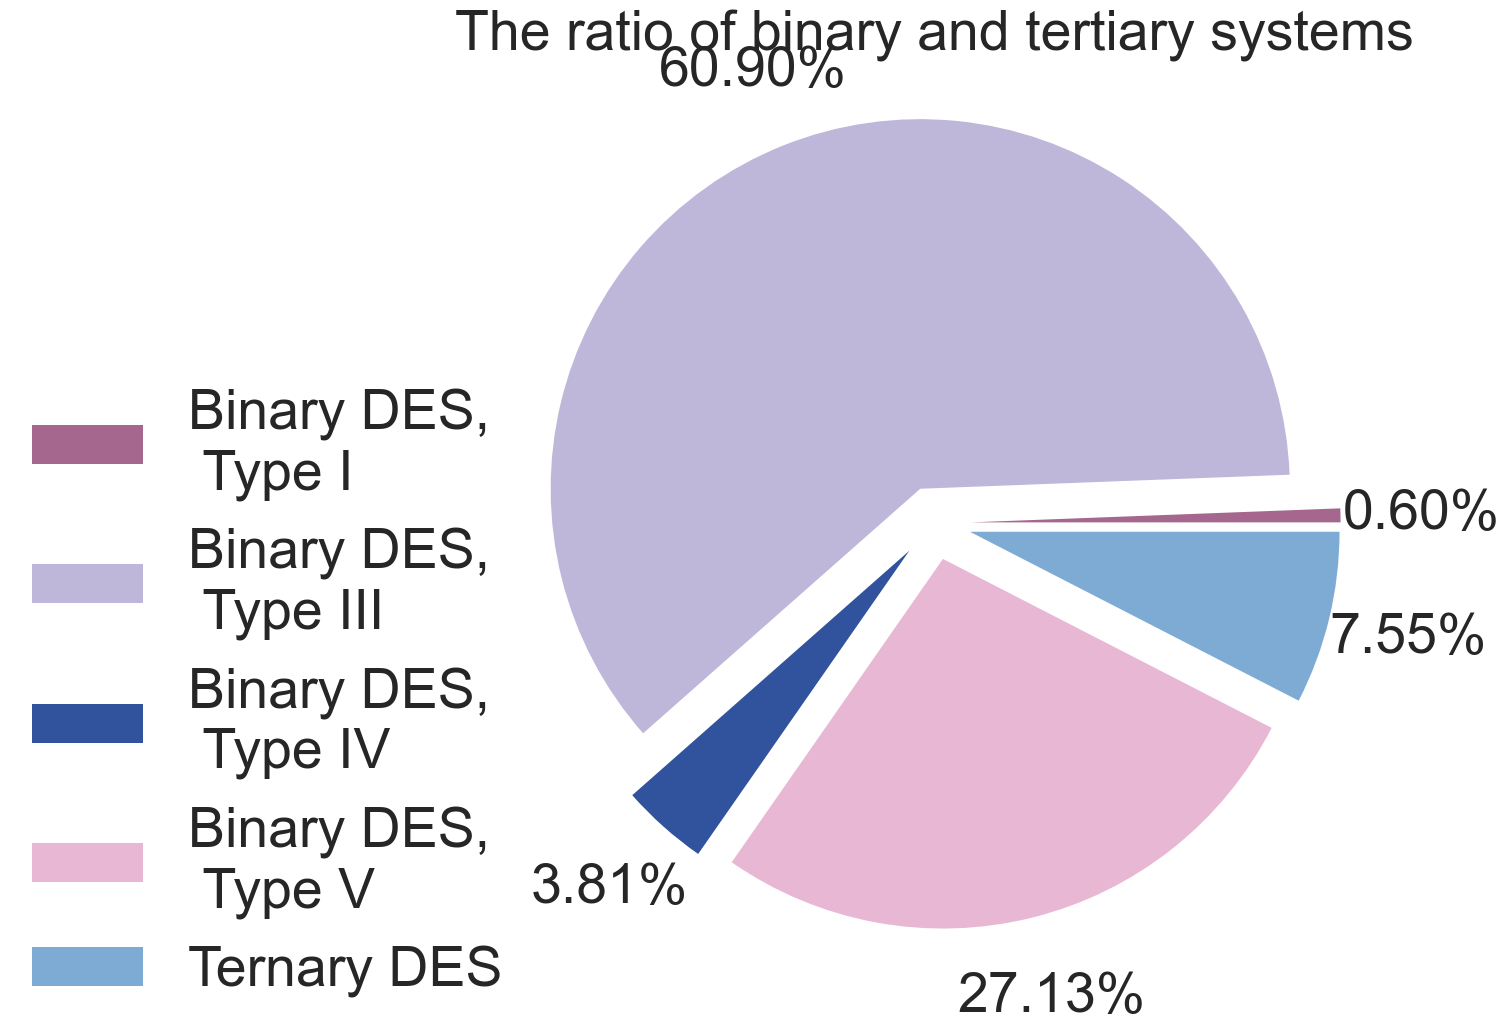

In [51]:
colors = ['#a5678e', '#beb7d9', '#31539d','#e8b7d4', '#7eabd4'] # Palette of colors
fig, ax = plt.subplots(figsize = (12, 12)) #Initialization - creating an empty graph
labels = ['Binary DES,\n Type I', 'Binary DES, \n Type III', 'Binary DES, \n Type IV', 'Binary DES,\n Type V', 'Ternary DES']
ax.pie(bin_ter['Density, g/cm^3'], colors = colors, autopct = '%1.2f%%', textprops={'fontsize': 40}, explode=[0.1, 0.1, 0.1, 0.1, 0.1], pctdistance=1.22, radius=1) #Change names, colors, add%, increase font
plt.legend(
    bbox_to_anchor = (-0.16, 0.45, 0.25, 0.25),
    loc = 'best', labels = labels, fontsize = 40)
ax.set_title('The ratio of binary and tertiary systems', fontsize = 40) #Title of a separate chart
plt.show() #Graph demonstration

It can be seen that most systems are binary, this is explained by a small number of articles on this topic.

### 4.1.2. The ratio of different types of DES for binary systems

In [52]:
# Grouping binary systems by type
types_bin = density_df[['Type of DES', 'Number of components']][density_df['Number of components'] == 2].groupby('Type of DES').agg('count') 
types_bin

,Number of components
Type of DES,
Ⅰ,26
Ⅲ,2620
Ⅳ,164
Ⅴ,1167


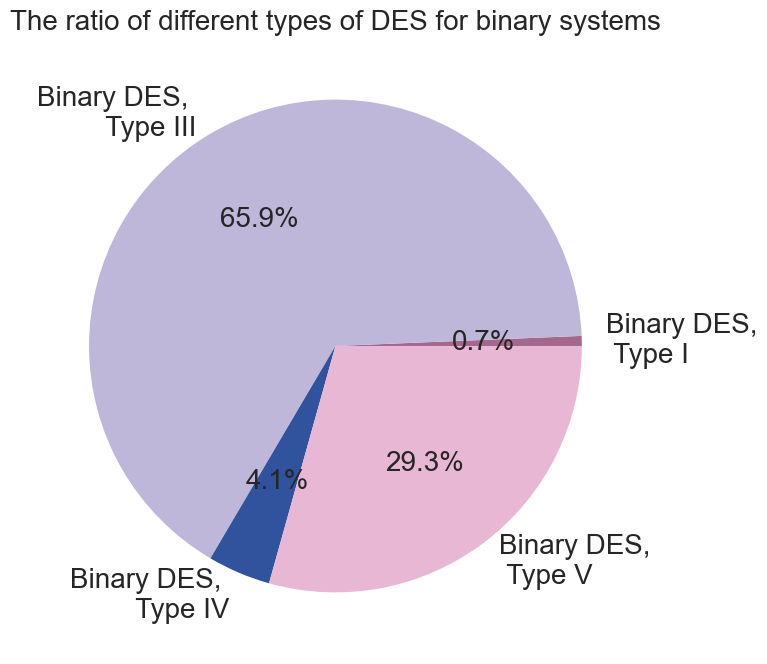

In [53]:
fig, ax = plt.subplots(figsize = (12, 8)) #Initialization - creating an empty graph
ax.pie(types_bin['Number of components'], labels = ['Binary DES,\n Type I', 'Binary DES, \n Type III', 'Binary DES, \n Type IV', 'Binary DES,\n Type V'], colors = colors, autopct = '%1.1f%%', textprops={'fontsize': 20}) #Change names, colors, add%, increase font
ax.set_title('The ratio of different types of DES for binary systems', fontsize = 20) #Title of a separate chart
plt.show() #Graph demonstration

Most systems belong to type III and V, as they are more often studied by scientists. There are no type II systems, since due to the fact that they consist of hydrate and ammonium salt, it is more correct to add them to tertiary systems, where the third component will be water

### 4.1.3. The most popular components of binary systems


#### 4.1.3.1. The most popular acceptor

In [54]:
#Table for the number of unique systems in various articles
max_comp = density_df[density_df['Number of components'] == 2][['Component#1','Component#2', 'Reference (DOI)']].groupby(['Component#1','Component#2']).agg('nunique')
max_comp = max_comp.sort_values('Reference (DOI)', ascending = False)
#To understand the number of times a particular acceptor participates in various systems, we reset the indexes and regroup the samples
max_comp.reset_index(level=[0,1], inplace = True)
#Regrouping
max_acceptor = max_comp[['Component#1', 'Reference (DOI)']].groupby('Component#1').agg('sum')
max_acceptor = max_acceptor.sort_values('Reference (DOI)', ascending = False)

max_acceptor['Component#1'] = max_acceptor.index
f_get_upper = lambda x: x.upper()
max_acceptor['Component#1'] = max_acceptor['Component#1'].apply(f_get_upper)
max_acceptor.index = max_acceptor['Component#1']
max_acceptor

,Reference (DOI),Component#1
Component#1,,
CHOLINE CHLORIDE,144,CHOLINE CHLORIDE
MENTHOL,46,MENTHOL
THYMOL,36,THYMOL
BETAINE,24,BETAINE
TETRABUTYLAMMONIUM BROMIDE,20,TETRABUTYLAMMONIUM BROMIDE
...,...,...
L-CARNITINE,1,L-CARNITINE
LAURAMINE OXIDE,1,LAURAMINE OXIDE
1-BUTYL-3-METHYLIMIDAZOLIUM CHLORIDE,1,1-BUTYL-3-METHYLIMIDAZOLIUM CHLORIDE


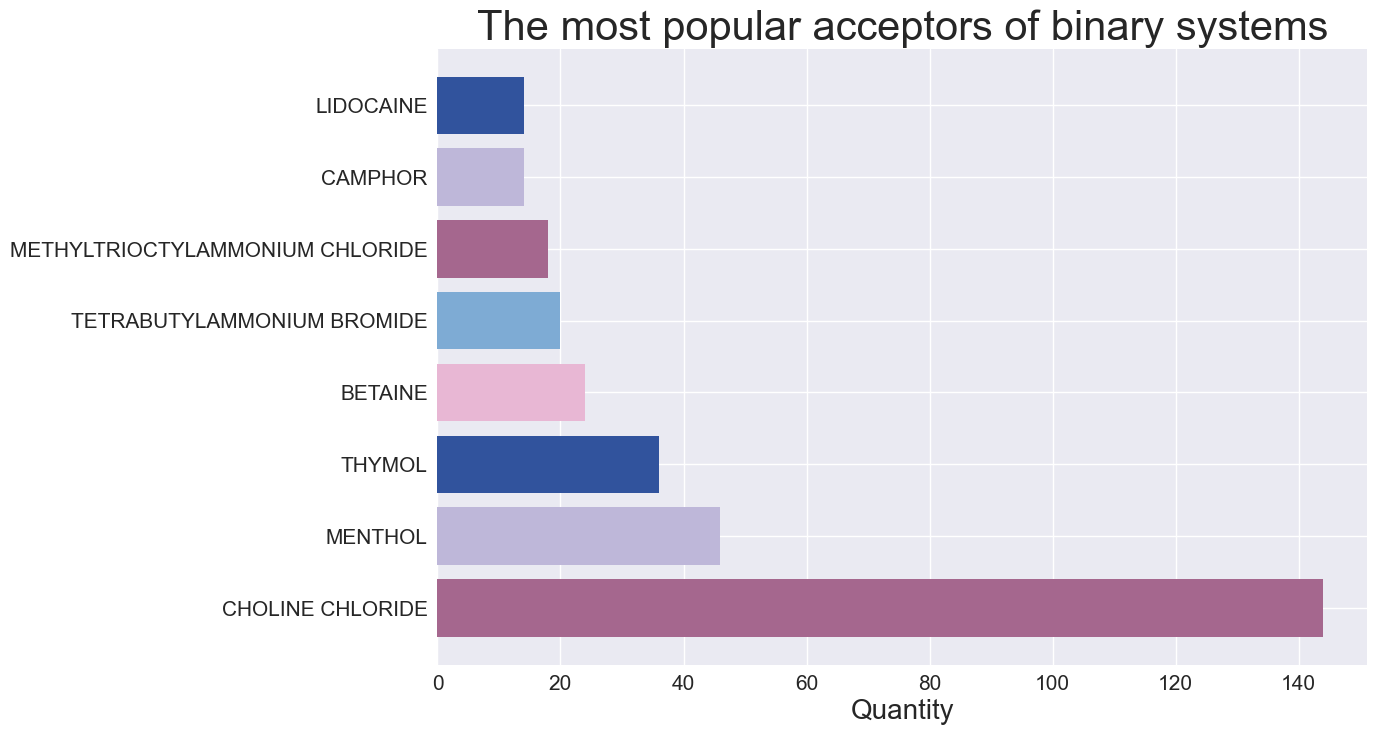

In [55]:
fig, ax = plt.subplots(figsize = (12, 8)) # Chart initialization
ax.barh(max_acceptor.head(8).index, max_acceptor.head(8)['Reference (DOI)'], color = colors) # Building a bar chart
ax.set_title('The most popular acceptors of binary systems', fontsize = 30) # Title
ax.set_xlabel('Quantity', fontsize = 20) # X-axis signature
ax.set_yticks(max_acceptor.index[0:8])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show() #Demonstration

The most popular acceptor is choline chloride, it corresponds to 1540 records, the rest are less than 204

#### 4.1.3.2. The most popular donor

In [56]:
#To understand the number of times a particular donor participates in various systems, we reset the indexes and regroup the samples
max_donor = max_comp[['Component#2', 'Reference (DOI)']].groupby('Component#2').agg('sum')
max_donor = max_donor.sort_values('Reference (DOI)', ascending = False) #Sort in descending order
max_donor['Component#2'] = max_donor.index
f_get_upper = lambda x: x.upper()
max_donor['Component#2'] = max_donor['Component#2'].apply(f_get_upper)
max_donor.index = max_donor['Component#2']
max_donor
max_donor

,Reference (DOI),Component#2
Component#2,,
DECANOIC ACID,41,DECANOIC ACID
GLYCEROL,32,GLYCEROL
ETHYLENE GLYCOL,30,ETHYLENE GLYCOL
LAURIC ACID,23,LAURIC ACID
OCTANOIC ACID,18,OCTANOIC ACID
...,...,...
BUTYRAMIDE,1,BUTYRAMIDE
BUTYLPARABEN,1,BUTYLPARABEN
ALPHA-TERPINEOL,1,ALPHA-TERPINEOL


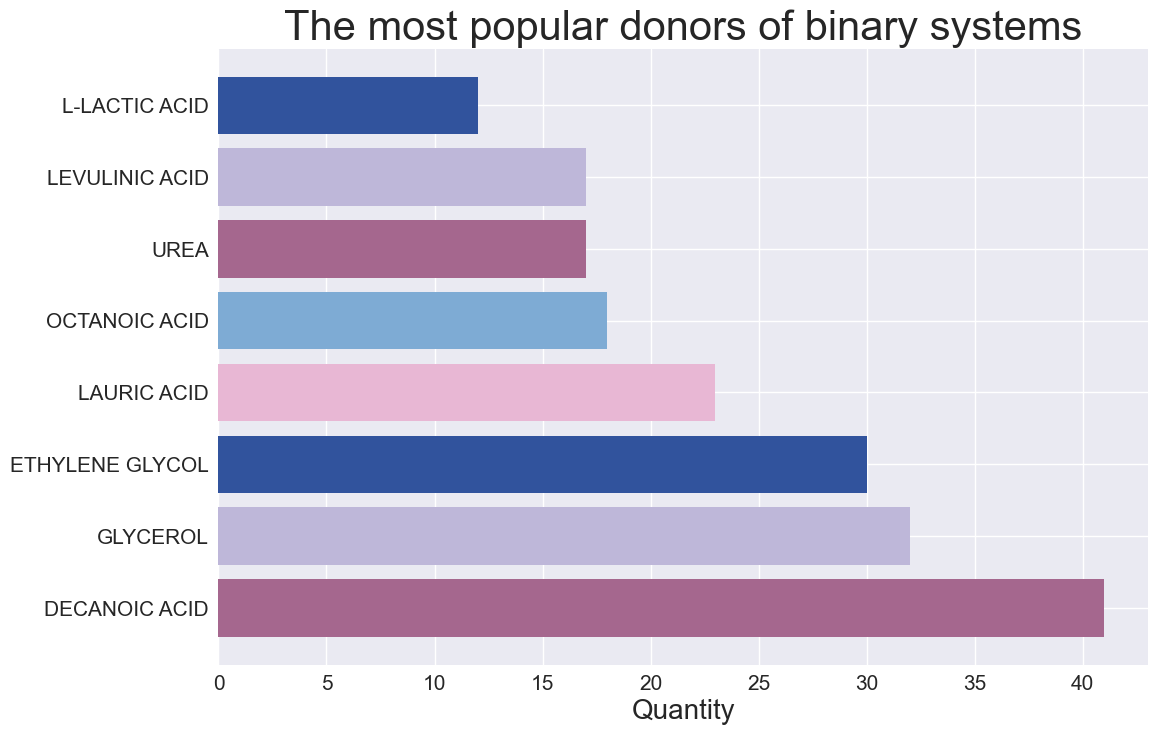

In [57]:
fig, ax = plt.subplots(figsize = (12, 8)) # Chart initialization
ax.barh(max_donor.head(8).index, max_donor.head(8)['Reference (DOI)'], color = colors) # Building a bar chart
ax.set_title('The most popular donors of binary systems', fontsize = 30) # Title
ax.set_xlabel('Quantity', fontsize = 20) # X-axis signature
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show() #Demonstration

The distribution of donors is more uniform, the most popular are glycerin, ethylene glycol, lactic acid, citric acid

#### 4.1.3.3. The most popular system


In [58]:
#Grouping by two components
popular_system = density_df[density_df['Number of components'] == 2][['Component#1', 'Component#2', 'Density, g/cm^3']].groupby(['Component#1', 'Component#2']).agg('count')
popular_system = popular_system.sort_values('Density, g/cm^3', ascending = False) #Sort in descending order
popular_system.head(50)

Density, g/cm^3
Component#1                                      Component#2                                  
CHOLINE CHLORIDE                                 ETHYLENE GLYCOL                           152
                                                 L-Lactic acid                             150
                                                 4-methylphenol                            131
                                                 o-cresol                                  127
                                                 m-cresol                                  122
                                                 glycerol                                   85
                                                 1,4-BUTANEDIOL                             66
n,n-diethylethanolammonium chloride              ETHYLENE GLYCOL                            60
CHOLINE CHLORIDE                                 urea                                       59
n,n-diethylethanolammonium chloride              glycerol                                   58
Methyltriphenylphosphonium bromide               ETHYLENE GLYCOL                            55
                                                 glycerol                                   55
CHOLINE CHLORIDE                                 propylene glycol                           54
                                                 phenol                                     54
                                                 LEVULINIC ACID                             51
MENTHOL                                          octanoic acid                              50
CHOLINE CHLORIDE                                 Ethanolamine                               49
lidocaine                                        Decanoic acid                              47
MENTHOL                                          Decanoic acid                              45
CHOLINE CHLORIDE                                 malonic acid                               42
                                                 1,3-PROPANEDIOL                            40
Decanoic acid                                    lauric acid                                37
Aluminium chloride anhydrous                     Butyramide                                 35
                                                 PROPIONAMIDE                               34
Allyltriphenylphosphonium bromide                DIETHYLENE GLYCOL                          33
                                                 TRIETHYLENE GLYCOL                         33
THYMOL                                           Decanoic acid                              32
Methyltriphenylphosphonium bromide               Ethanolamine                               31
Tetrabutylammonium bromide                       Ethanolamine                               29
Aluminium chloride anhydrous                     acetamide                                  28
CHOLINE CHLORIDE                                 D-Arabino-Hex-2-ulo-Pyranose               28
Ethylamine hydrochloride                         glycerol                                   28
CHOLINE CHLORIDE                                 malic acid                                 28
betaine                                          LEVULINIC ACID                             28
Tetrabutylammonium chloride                      TRIETHYLENE GLYCOL                         28
TETRAETHYLAMMONIUM CHLORIDE                      3-Aminopropan-1-ol                         27
Tetrabutylammonium bromide                       3-Aminopropan-1-ol                         27
Tetrabutylammonium chloride                      3-Aminopropan-1-ol                         27
MENTHOL                                          L-Lactic acid                              26
l-Menthol                                        lauric acid                                26
imidazole                                        Ethanolamine                            

The most popular Choline chloride system is Ethylene glycol

## 4.2. Distribution of density values
At this stage we will consider the distributions of density values

### 4.2.1. Density distribution for all values

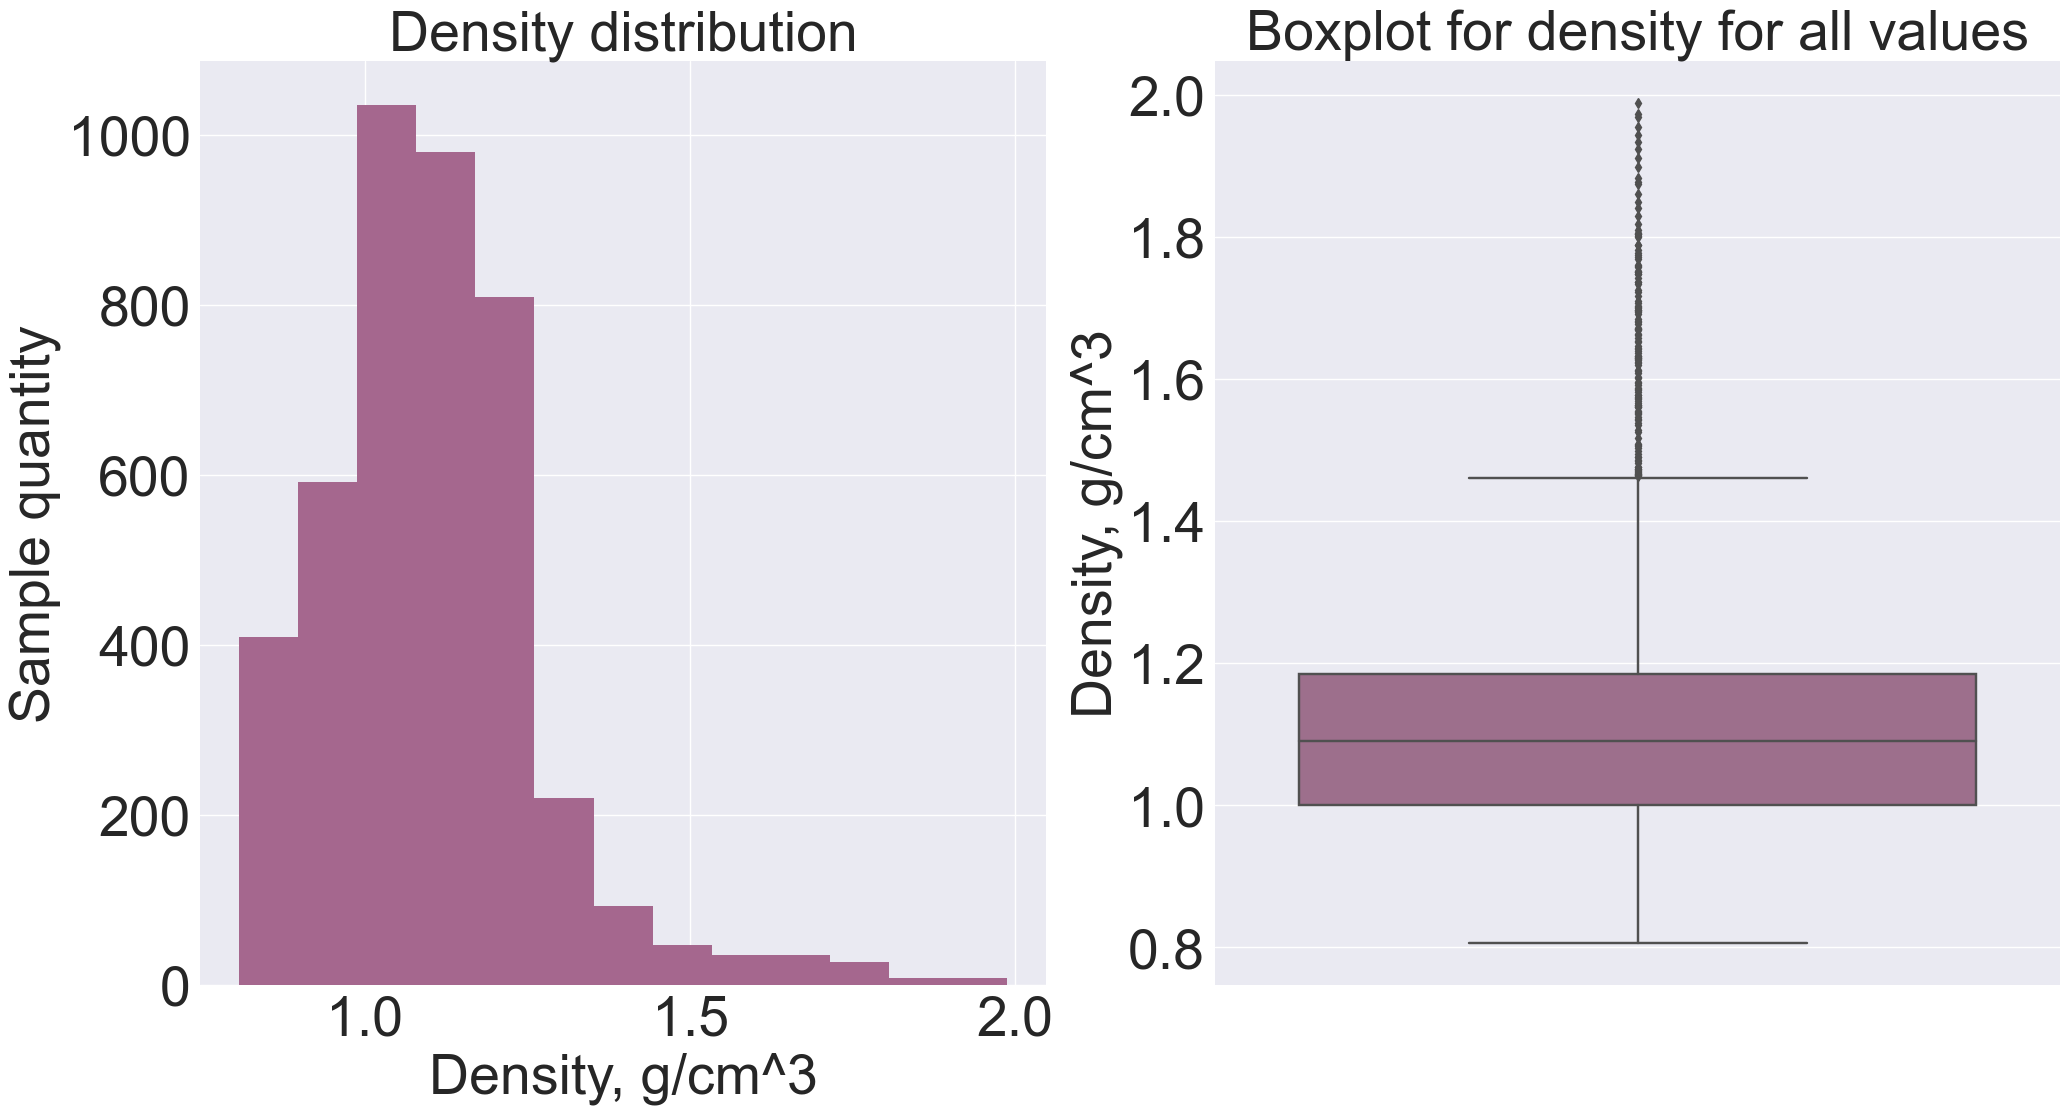

In [59]:
fig_time, ax_time = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Initialization
ax_time[0].hist(density_df['Density, g/cm^3'], color = colors[0], bins = 13) # Building a histogram
ax_time[0].set_title('Density distribution', fontsize=40) #Title
ax_time[0].set_xlabel('Density, g/cm^3', fontsize=40) #X-axis signature
ax_time[0].set_ylabel('Sample quantity', fontsize=40) #Signature of the Y axis
ax_time[0].tick_params(axis='both', which='major', labelsize=40)
ax_time[1]= sns.boxplot(y = density_df['Density, g/cm^3'], palette = colors) #Building a boxplot
ax_time[1].set_title('Boxplot for density for all values', fontsize=40) #Title
ax_time[1].set_ylabel('Density, g/cm^3', fontsize=40) #Signature of the Y axis
ax_time[1].tick_params(axis='both', which='major', labelsize=40)
plt.show() 

The distribution has a tail from 1.5 to 2.0 - these are atypical density values, but they are often found

### 4.2.2. Density distribution for two-component and three-component systems

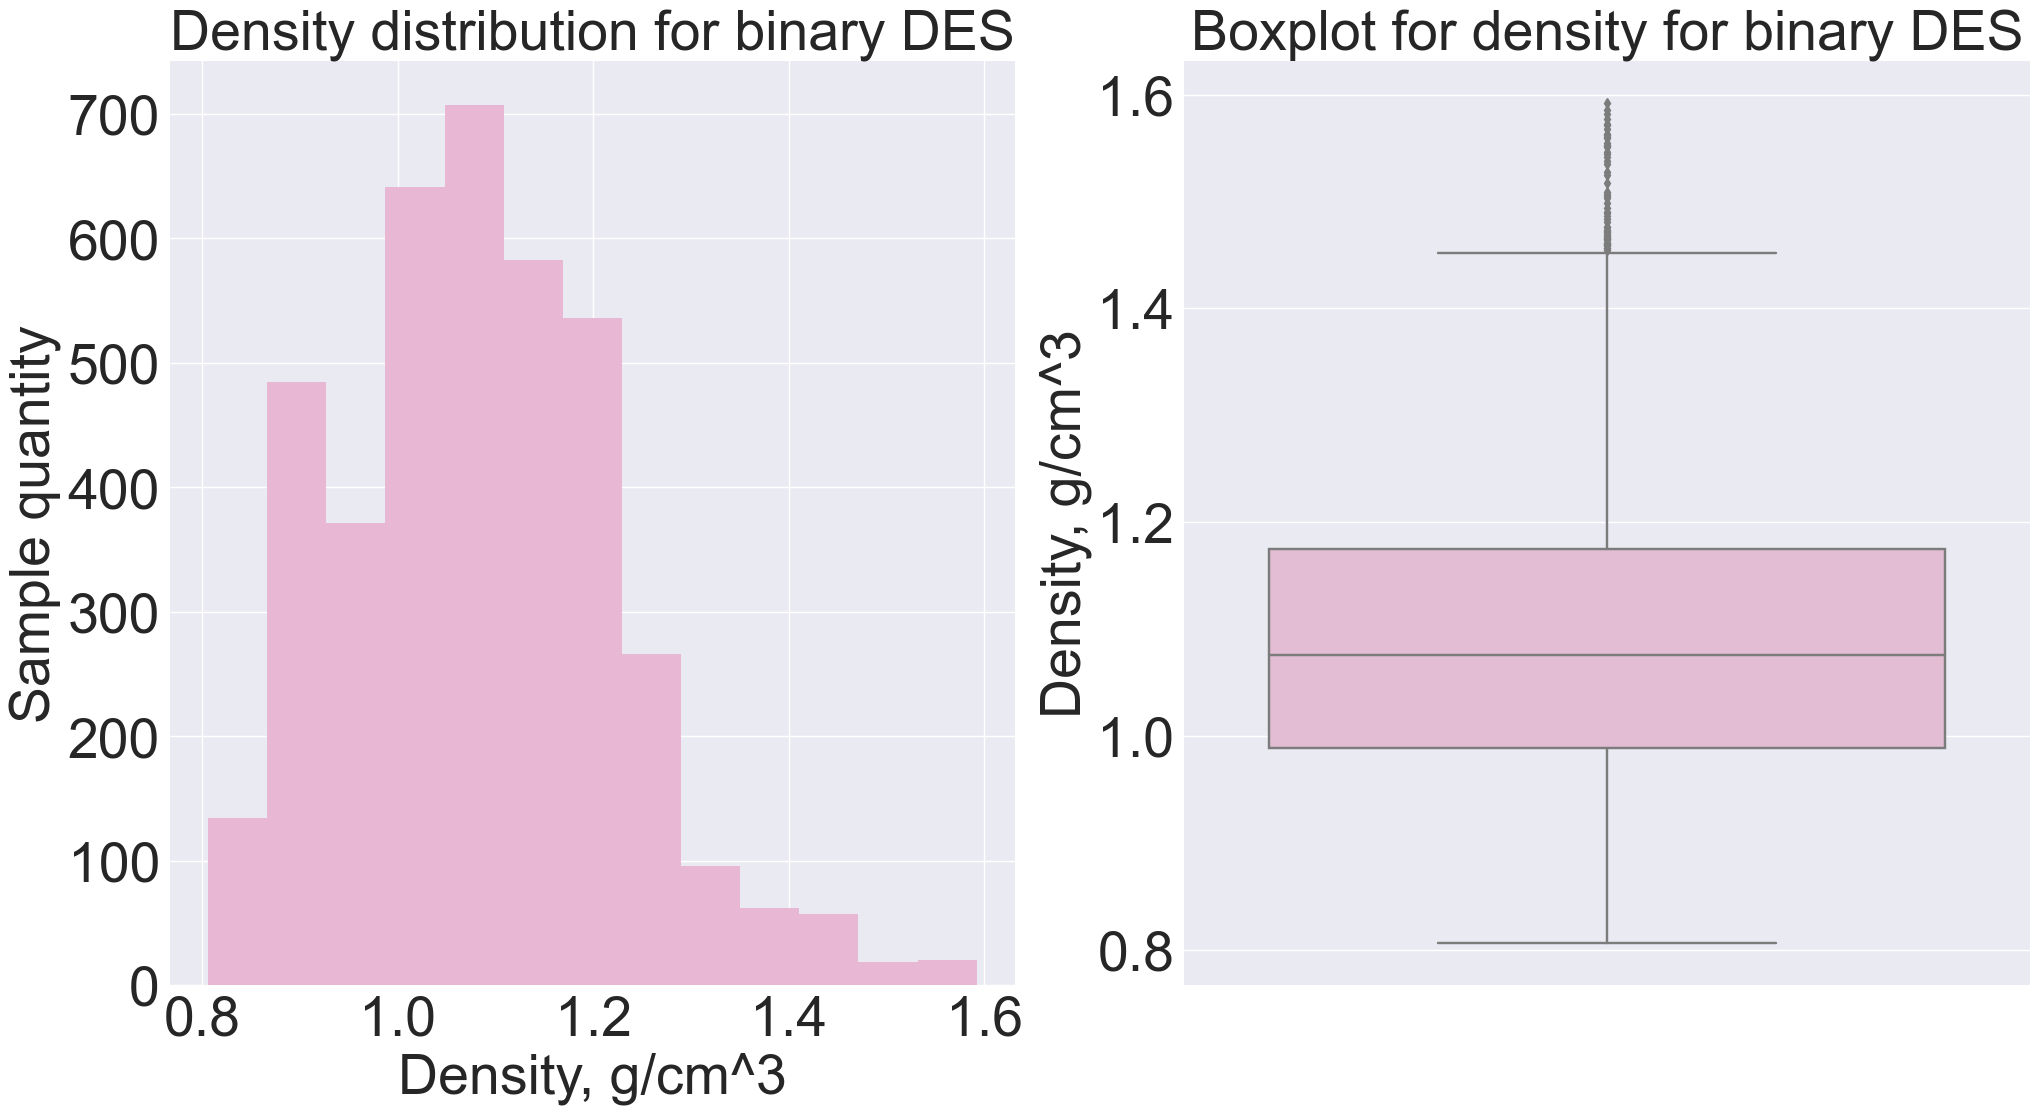

In [60]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Initialization
ax[0].hist(density_df[density_df['Number of components'] == 2]['Density, g/cm^3'], color = colors[3], bins = 13) # Building a histogram
ax[0].set_title('Density distribution for binary DES', fontsize=40) #Title
ax[0].set_xlabel('Density, g/cm^3', fontsize=40) #X-axis signature
ax[0].set_ylabel('Sample quantity', fontsize=40) #Signature of the Y axis
ax[0].tick_params(axis='both', which='major', labelsize=40)
ax[1] = sns.boxplot(y = density_df[density_df['Number of components'] == 2]['Density, g/cm^3'], color = colors[3]) #Building a boxplot
ax[1].set_title('Boxplot for density for binary DES', fontsize=40) #Title
ax[1].set_ylabel('Density, g/cm^3', fontsize=40) #Signature of the Y axis
ax[1].tick_params(axis='both', which='major', labelsize=40)
plt.show()

The distribution has a tail from 1.4 to 1.6 - these are atypical density values, but they are often found

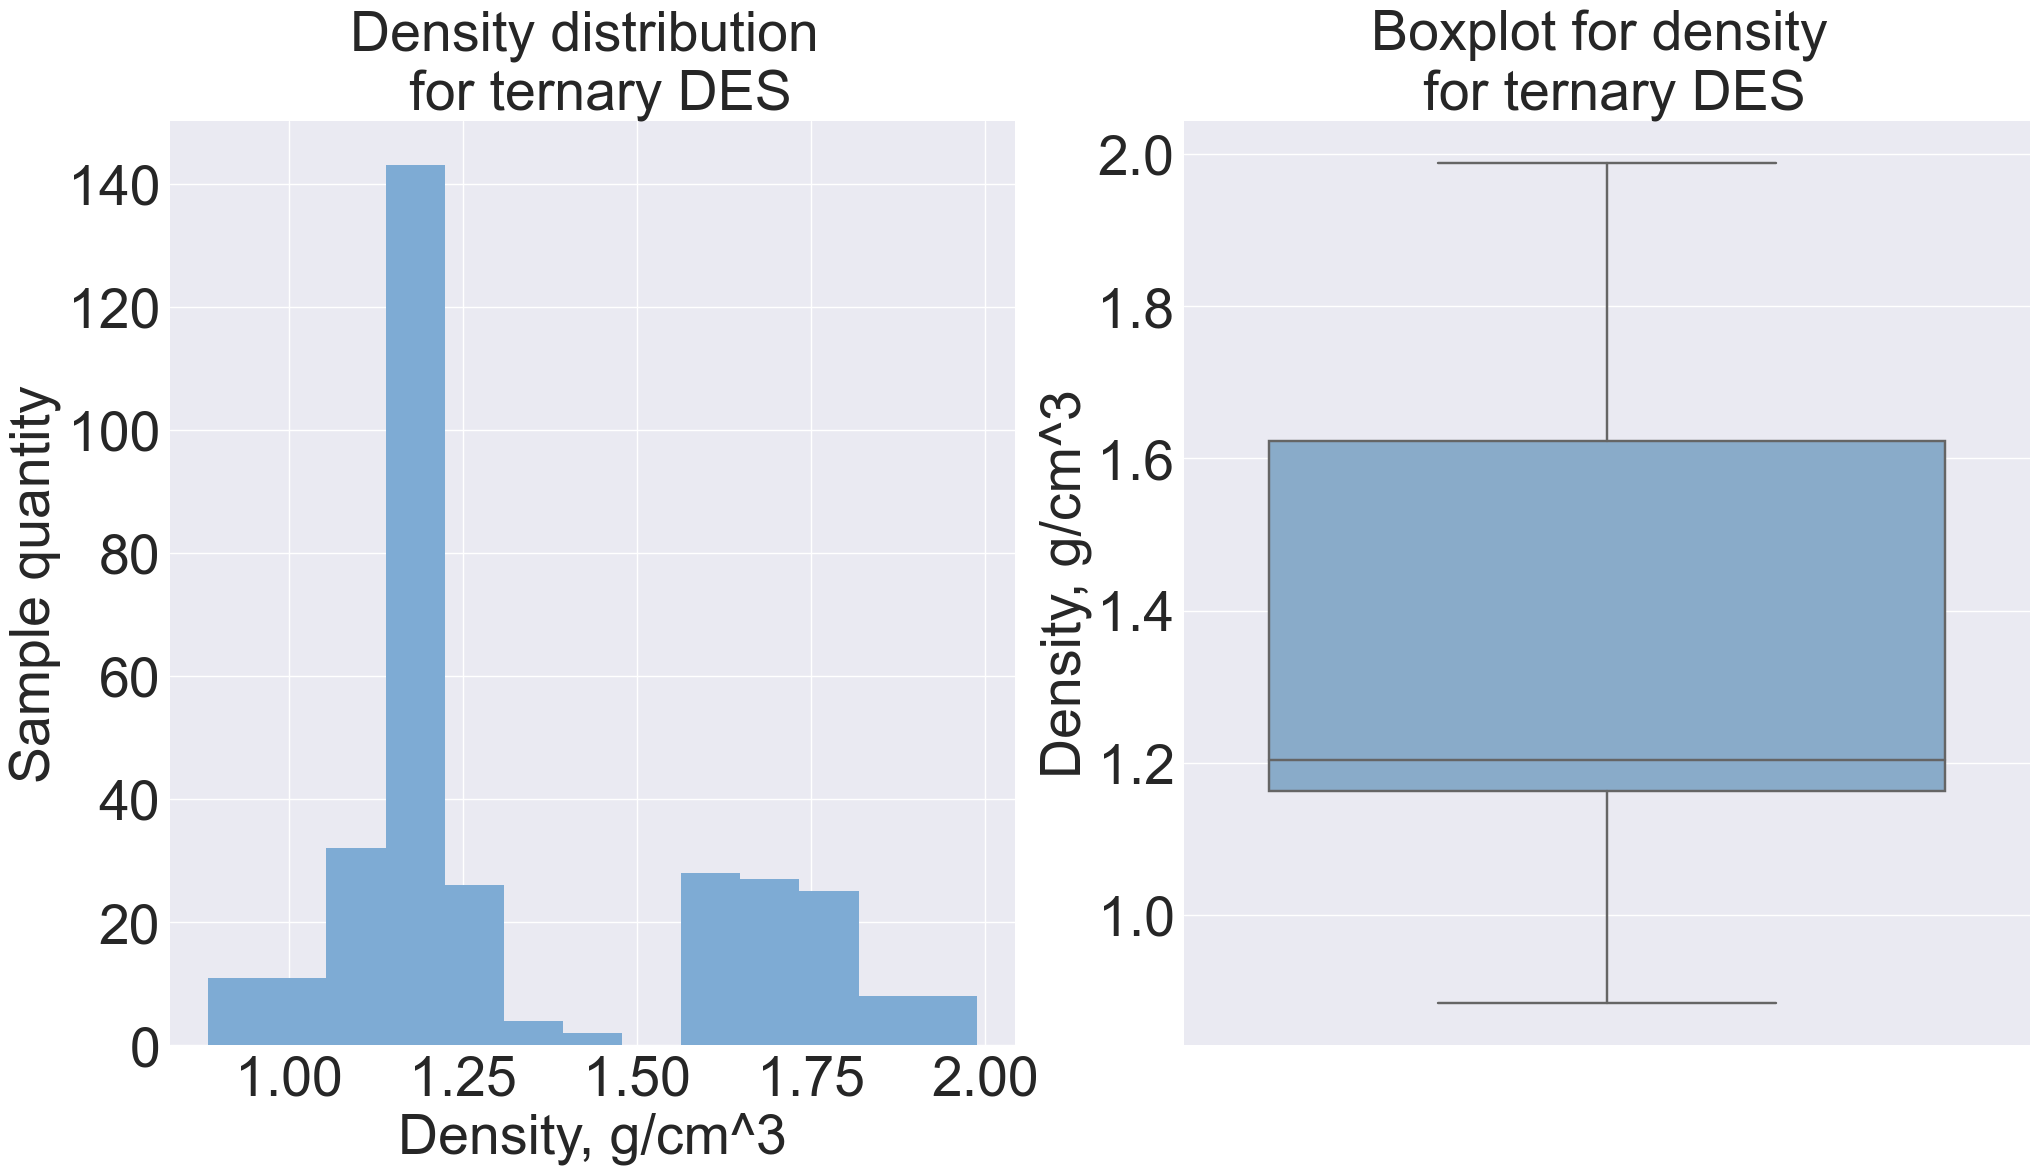

In [61]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Initialization
ax[0].hist(density_df[density_df['Number of components'] == 3]['Density, g/cm^3'], color = colors[4], bins = 13) # Building a histogram
ax[0].set_title('Density distribution \n for ternary DES', fontsize=40) #Title
ax[0].set_xlabel('Density, g/cm^3', fontsize=40) #X-axis signature
ax[0].set_ylabel('Sample quantity', fontsize=40) #Signature of the Y axis
ax[0].tick_params(axis='both', which='major', labelsize=40)
ax[1] = sns.boxplot(y = density_df[density_df['Number of components'] == 3]['Density, g/cm^3'], color = colors[4]) #Building a boxplot
ax[1].set_title('Boxplot for density \n for ternary DES', fontsize=40) #Title
ax[1].set_ylabel('Density, g/cm^3', fontsize=40) #Signature of the Y axis
ax[1].tick_params(axis='both', which='major', labelsize=40)
plt.show() 

The distribution is divided into two parts: about 1,2 and about 1,7, this may be explained by the presence in the database of triple systems consisting mainly of organics and triple systems containing ammonium salts and metal salts

### 4.2.3. Density distribution for different types of binary systems

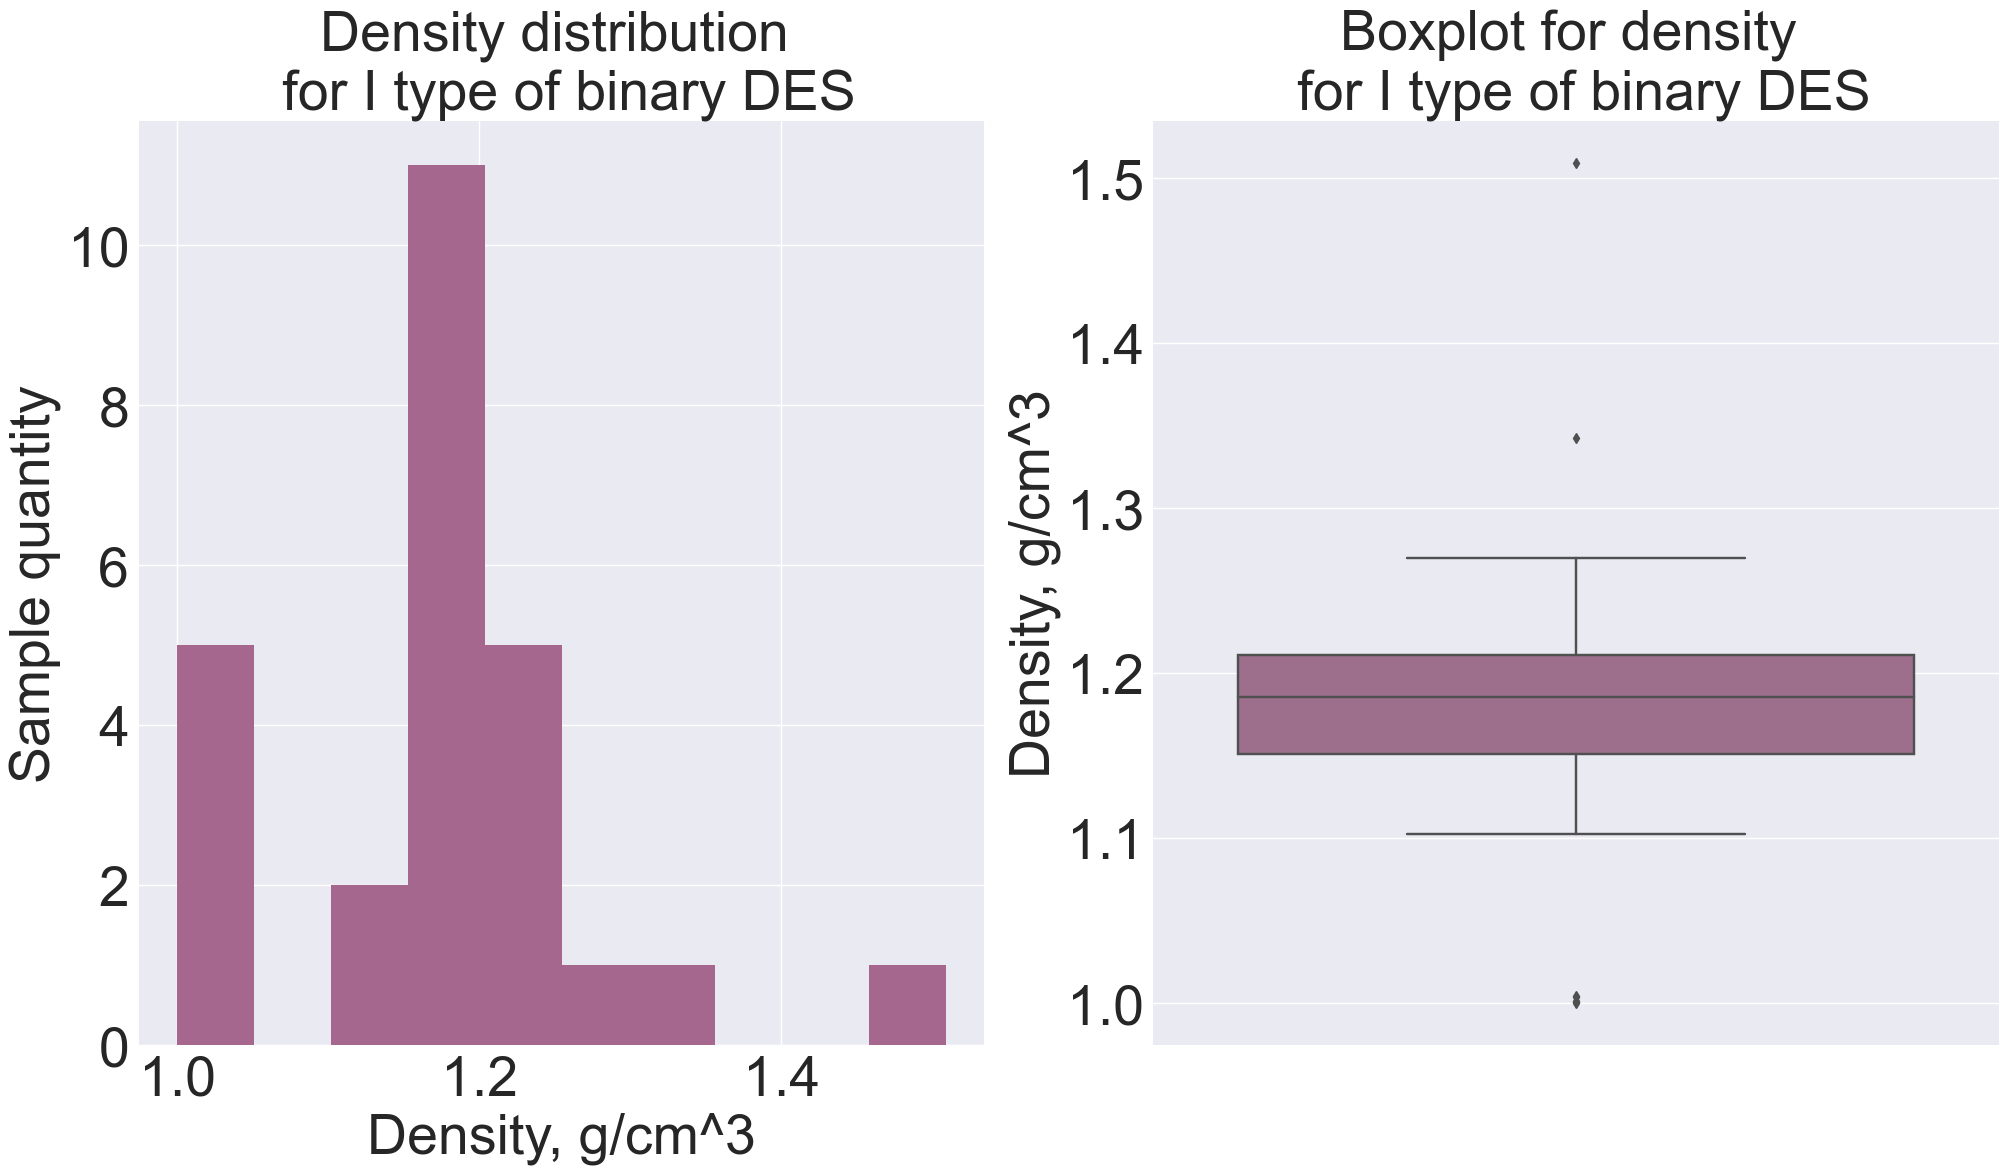

In [62]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Initialization
ax[0].hist(density_df[density_df['Type of DES'] == 'Ⅰ']['Density, g/cm^3'], color = colors[0]) # Building a histogram
ax[0].set_title('Density distribution \n for I type of binary DES', fontsize=40) #Title
ax[0].set_xlabel('Density, g/cm^3', fontsize=40) #X-axis signature
ax[0].set_ylabel('Sample quantity', fontsize=40) #Signature of the Y axis
ax[0].tick_params(axis='both', which='major', labelsize=40)
ax[1] = sns.boxplot(y = density_df[density_df['Type of DES'] == 'Ⅰ']['Density, g/cm^3'], color = colors[0]) #Building a boxplot
ax[1].set_title('Boxplot for density \n for I type of binary DES', fontsize=40) #Title
ax[1].set_ylabel('Density, g/cm^3', fontsize=40) #Signature of the Y axis
ax[1].tick_params(axis='both', which='major', labelsize=40)
plt.show() 

There is little DES type I data presented in the table, so the distribution is interrupted, there are several drop-down points in the region of 1.0 and 1.5

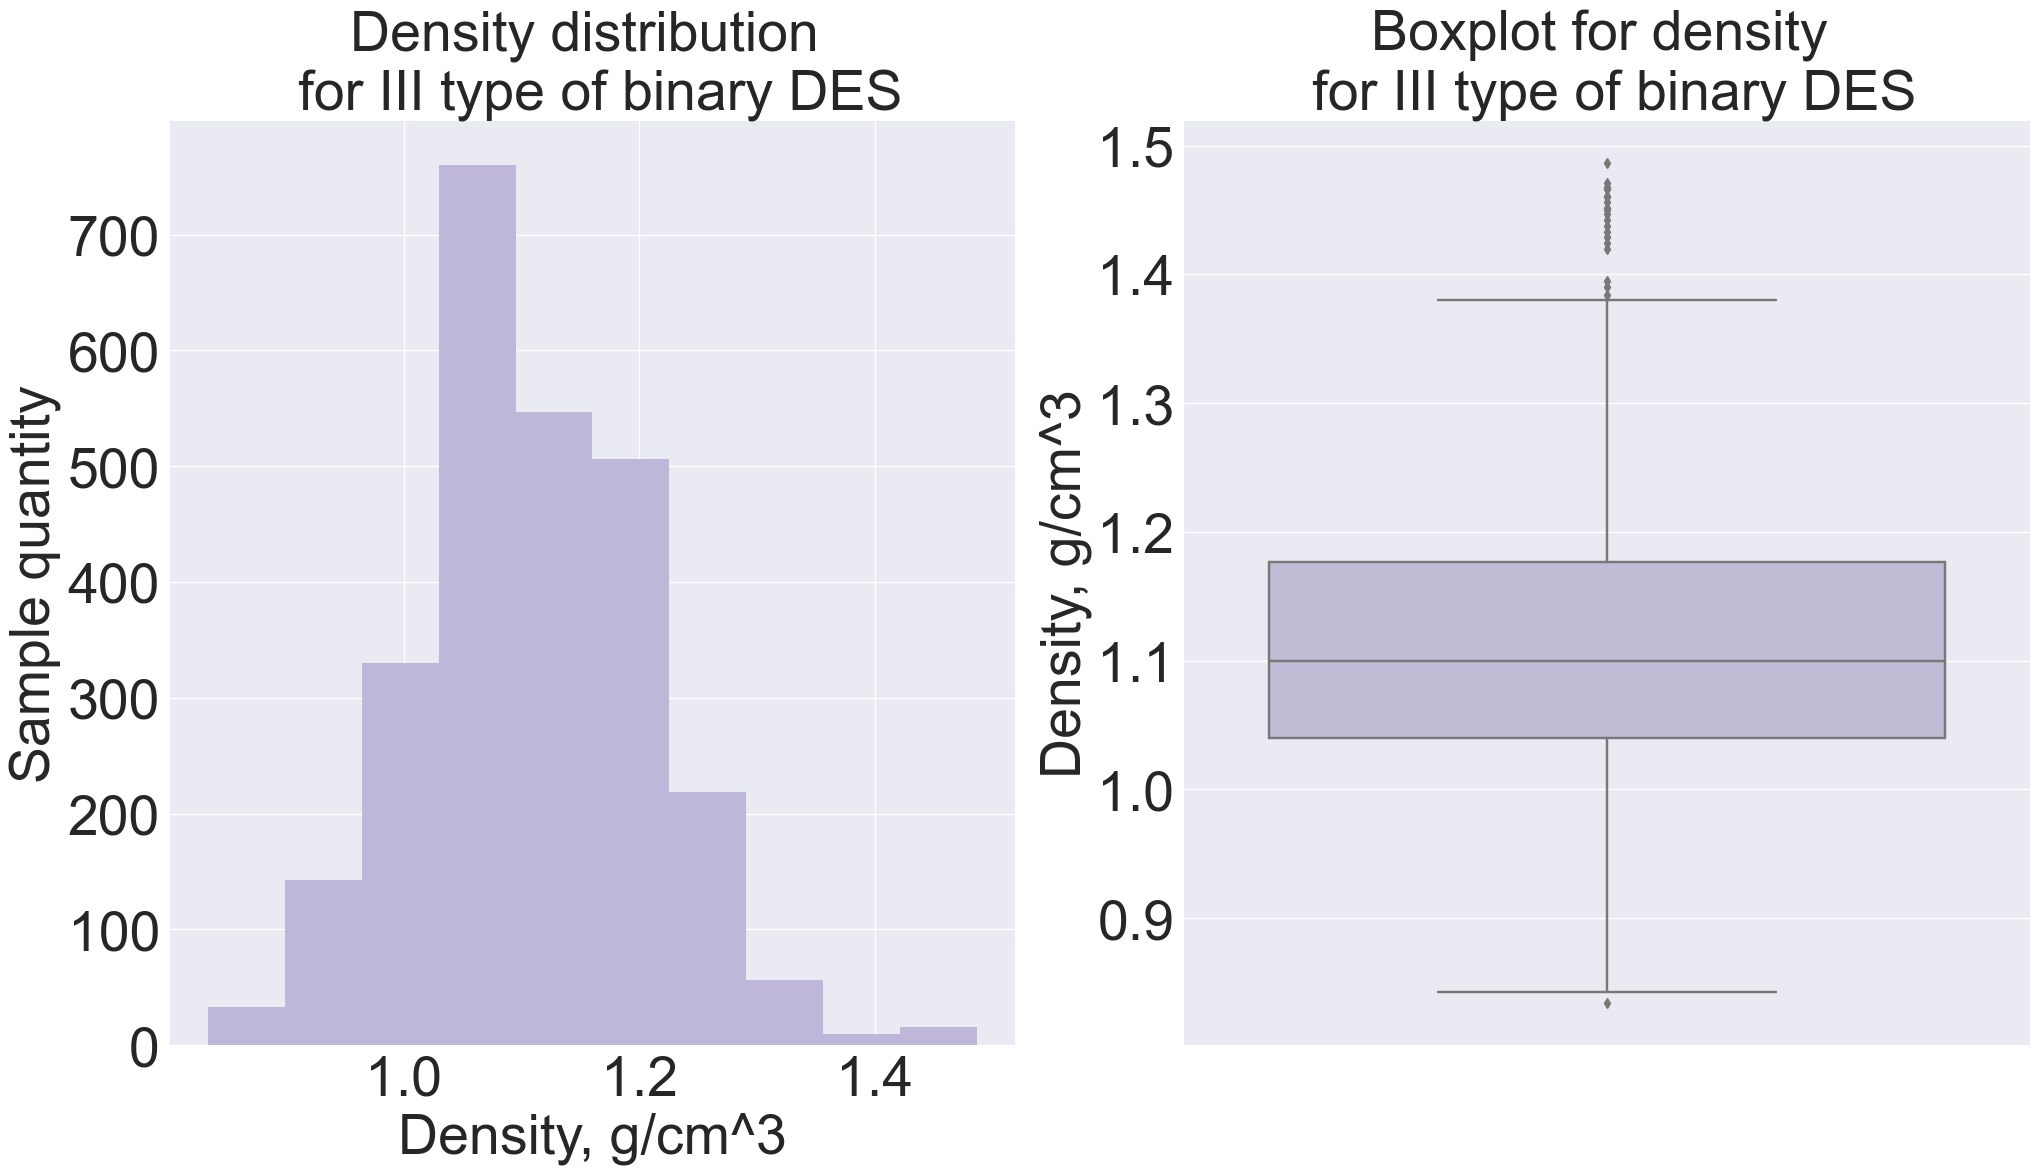

In [63]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Initialization
ax[0].hist(density_df[density_df['Type of DES'] == 'Ⅲ']['Density, g/cm^3'], color = colors[1]) # Building a histogram
ax[0].set_title('Density distribution \n for III type of binary DES', fontsize=40) #Title
ax[0].set_xlabel('Density, g/cm^3', fontsize=40) #X-axis signature
ax[0].set_ylabel('Sample quantity', fontsize=40) #Signature of the Y axis
ax[0].tick_params(axis='both', which='major', labelsize=40)
ax[1] = sns.boxplot(y = density_df[density_df['Type of DES'] == 'Ⅲ']['Density, g/cm^3'], color = colors[1]) #Building a boxplot
ax[1].set_title('Boxplot for density \n for III type of binary DES', fontsize=40) #Title
ax[1].set_ylabel('Density, g/cm^3', fontsize=40) #Signature of the Y axis
ax[1].tick_params(axis='both', which='major', labelsize=40)
plt.show() 

Distribution is close to normal, emissions in the region of 1.4-1.5 g/ml

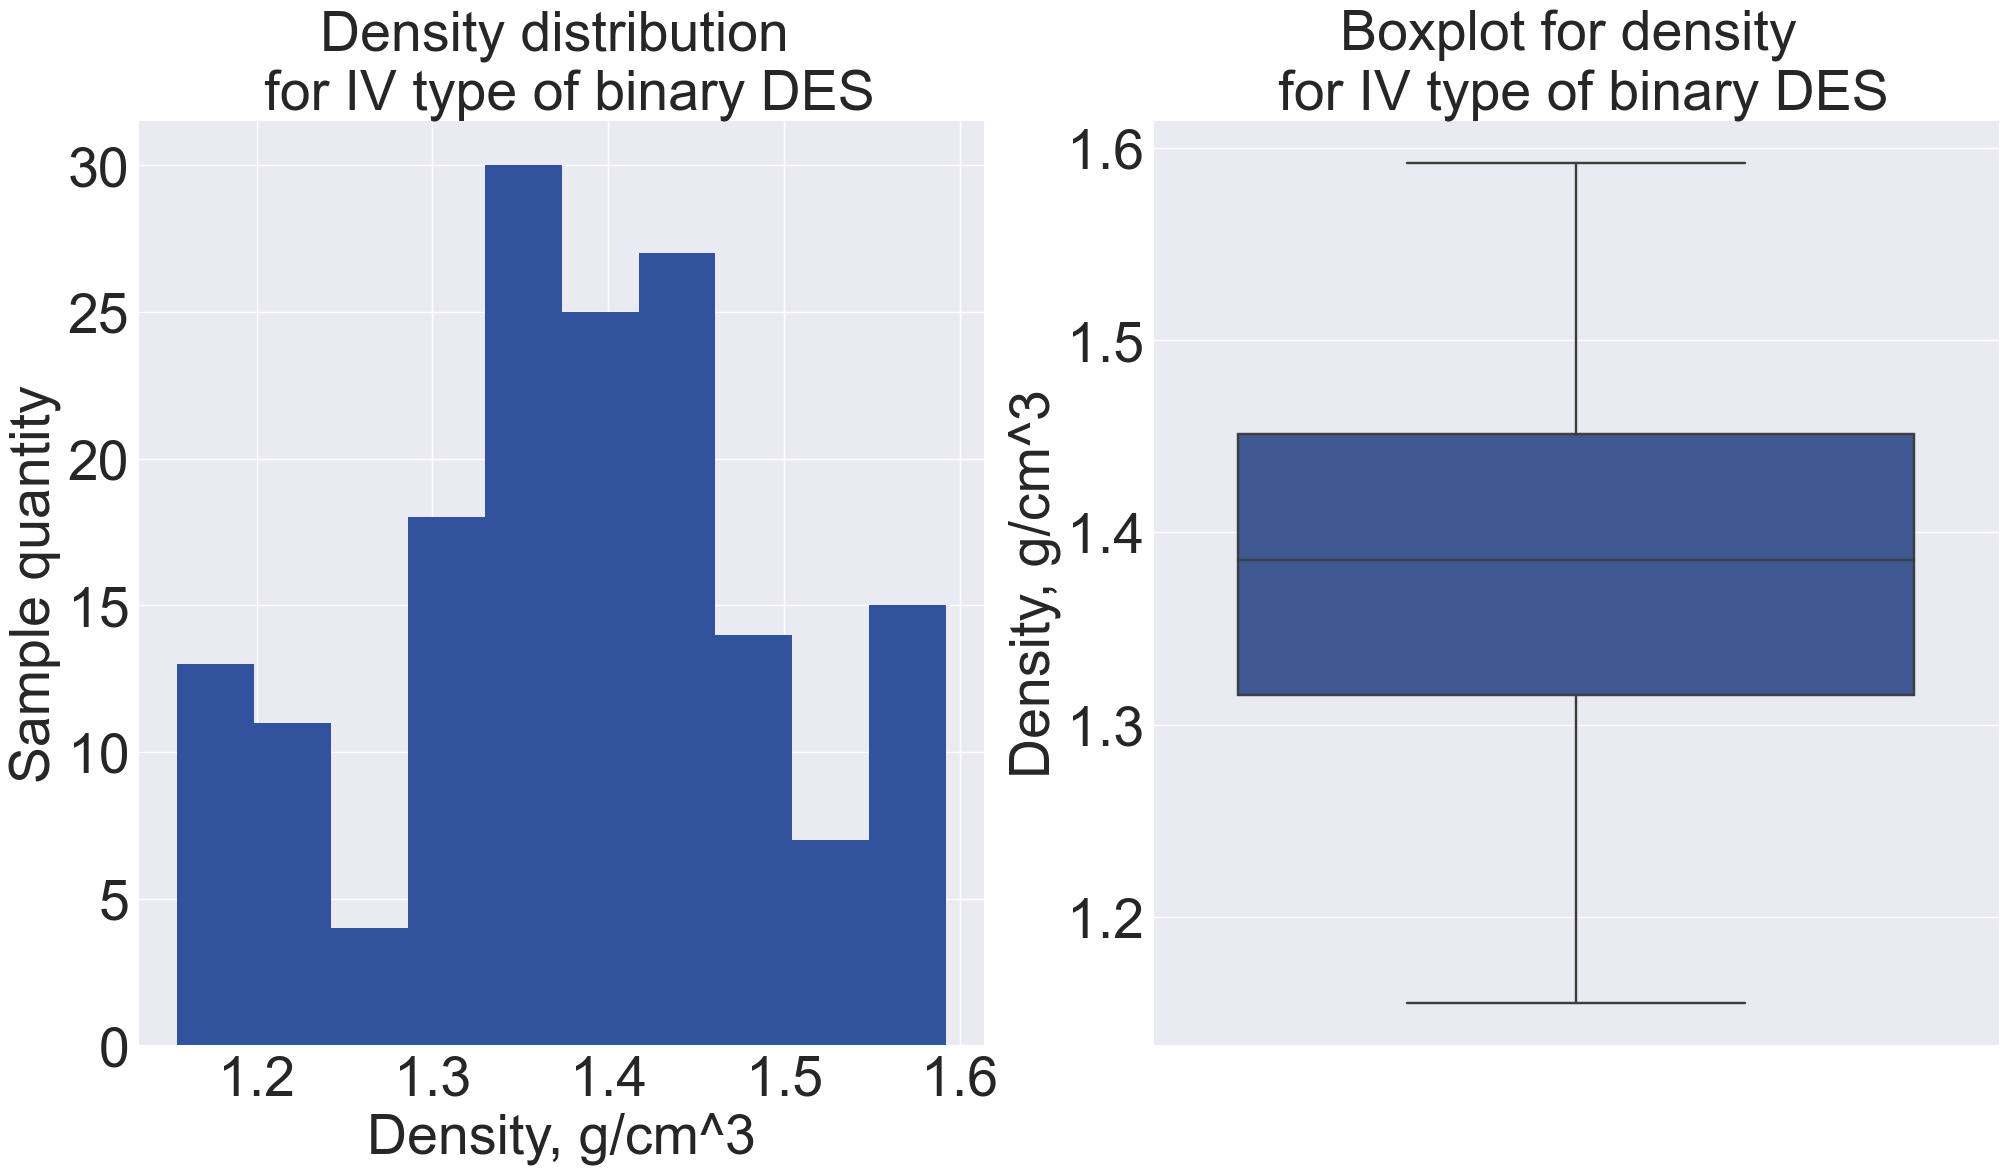

In [64]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Initialization
ax[0].hist(density_df[density_df['Type of DES'] == 'Ⅳ']['Density, g/cm^3'], color = colors[2]) # Building a histogram
ax[0].set_title('Density distribution \n for IV type of binary DES', fontsize=40) #Title
ax[0].set_xlabel('Density, g/cm^3', fontsize=40) #X-axis signature
ax[0].set_ylabel('Sample quantity', fontsize=40) #Signature of the Y axis
ax[0].tick_params(axis='both', which='major', labelsize=40)
ax[1] = sns.boxplot(y = density_df[density_df['Type of DES'] == 'Ⅳ']['Density, g/cm^3'], color = colors[2]) #Building a boxplot
ax[1].set_title('Boxplot for density \n for IV type of binary DES', fontsize=40) #Title
ax[1].set_ylabel('Density, g/cm^3', fontsize=40) #Signature of the Y axis
ax[1].tick_params(axis='both', which='major', labelsize=40)
plt.show() 

Two peaks are clearly visible in the area of 1.2 and in the area of 1.55

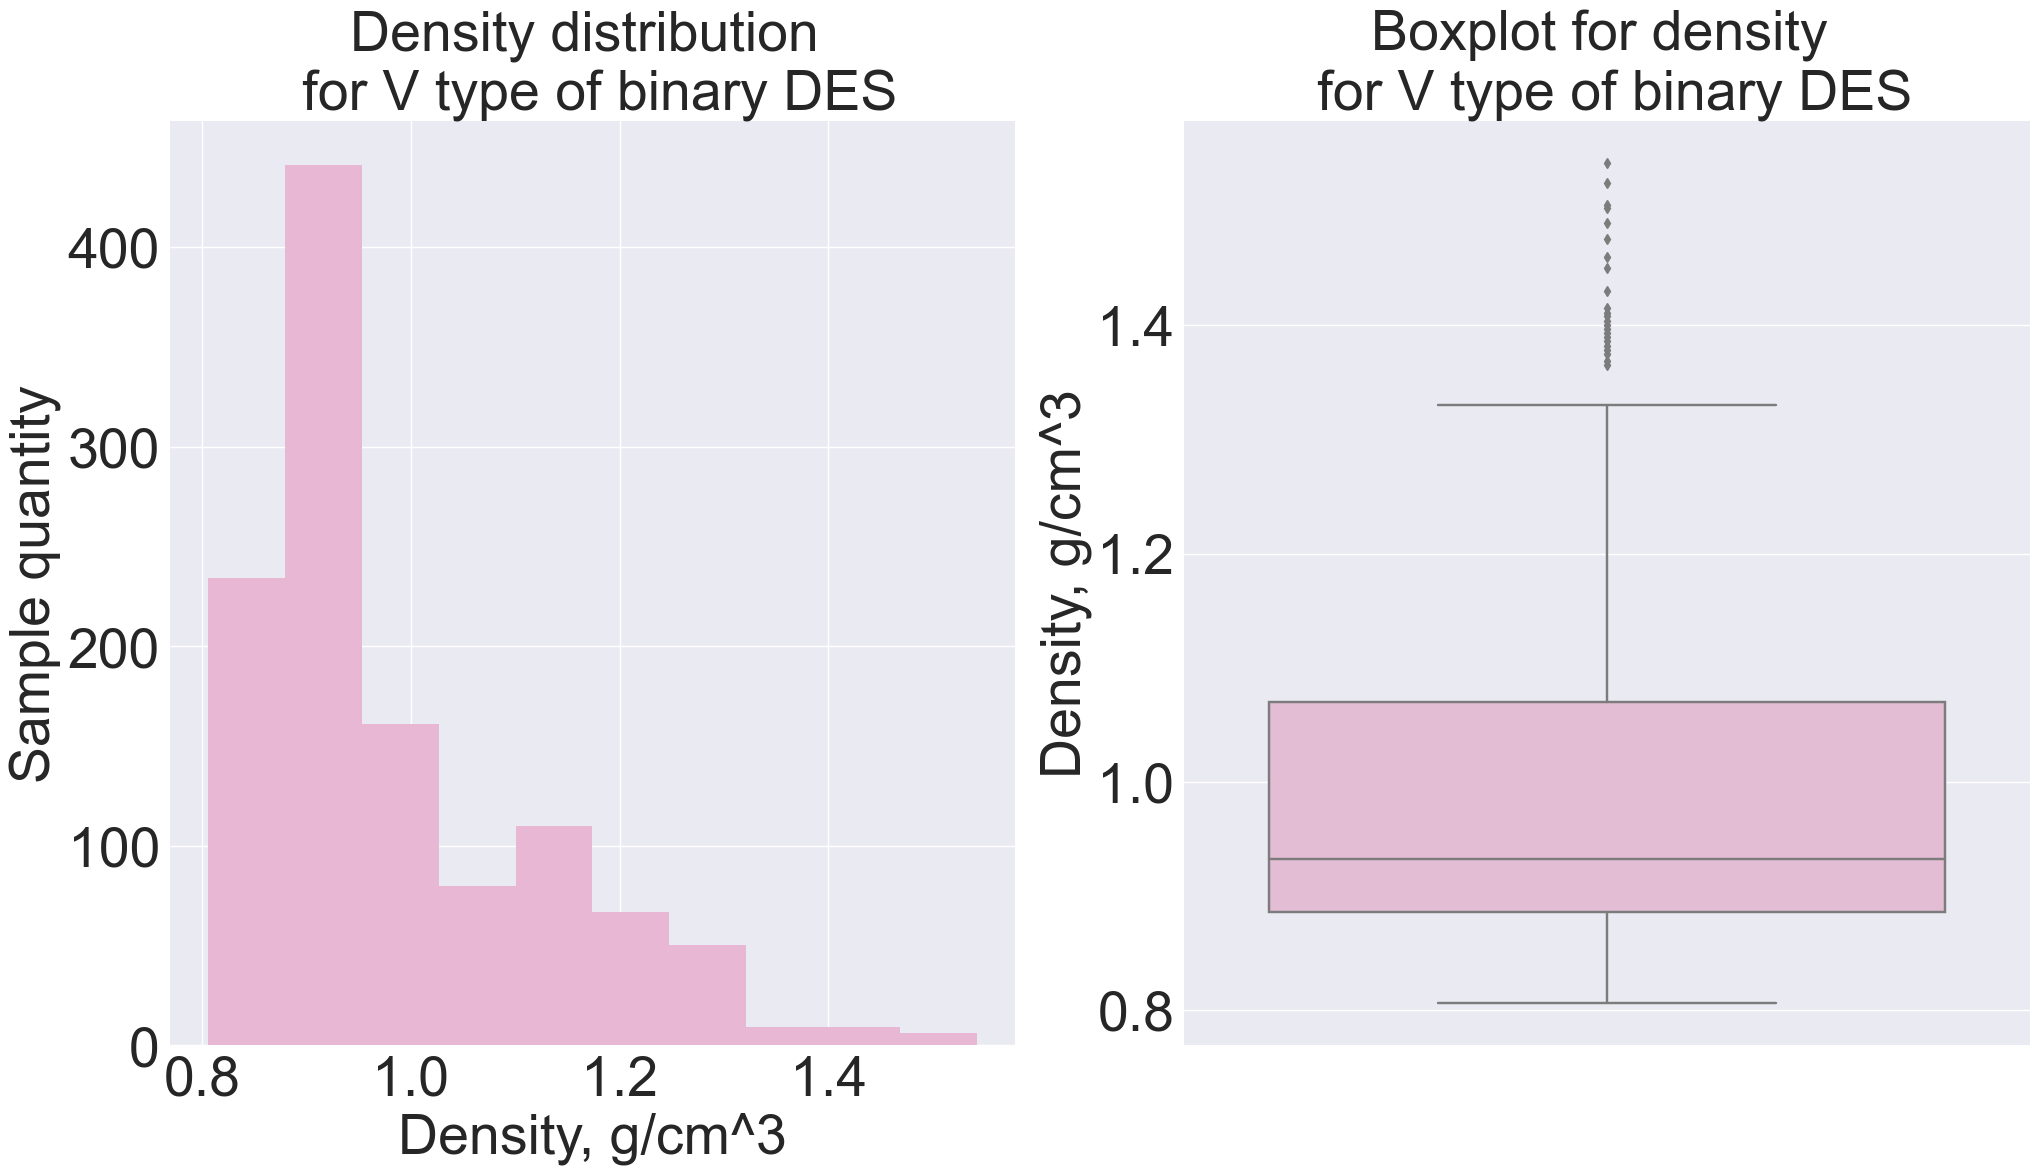

In [65]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 12)) # Initialization
ax[0].hist(density_df[density_df['Type of DES'] == 'Ⅴ']['Density, g/cm^3'], color = colors[3]) # Building a histogram
ax[0].set_title('Density distribution \n for V type of binary DES', fontsize=40) #Title
ax[0].set_xlabel('Density, g/cm^3', fontsize=40) #X-axis signature
ax[0].set_ylabel('Sample quantity', fontsize=40) #Signature of the Y axis
ax[0].tick_params(axis='both', which='major', labelsize=40)
ax[1] = sns.boxplot(y = density_df[density_df['Type of DES'] == 'Ⅴ']['Density, g/cm^3'], color = colors[3]) #Building a boxplot
ax[1].set_title('Boxplot for density \n for V type of binary DES', fontsize=40) #Title
ax[1].set_ylabel('Density, g/cm^3', fontsize=40) #Signature of the Y axis
ax[1].tick_params(axis='both', which='major', labelsize=40)
plt.show() 

They have the lowest density among all types of 0.9 - 1.0, since they consist of organic substances, emissions from 1.2, the distribution resembles normal, but there is a tail

## 4.3. Violinplots for density of different types DES

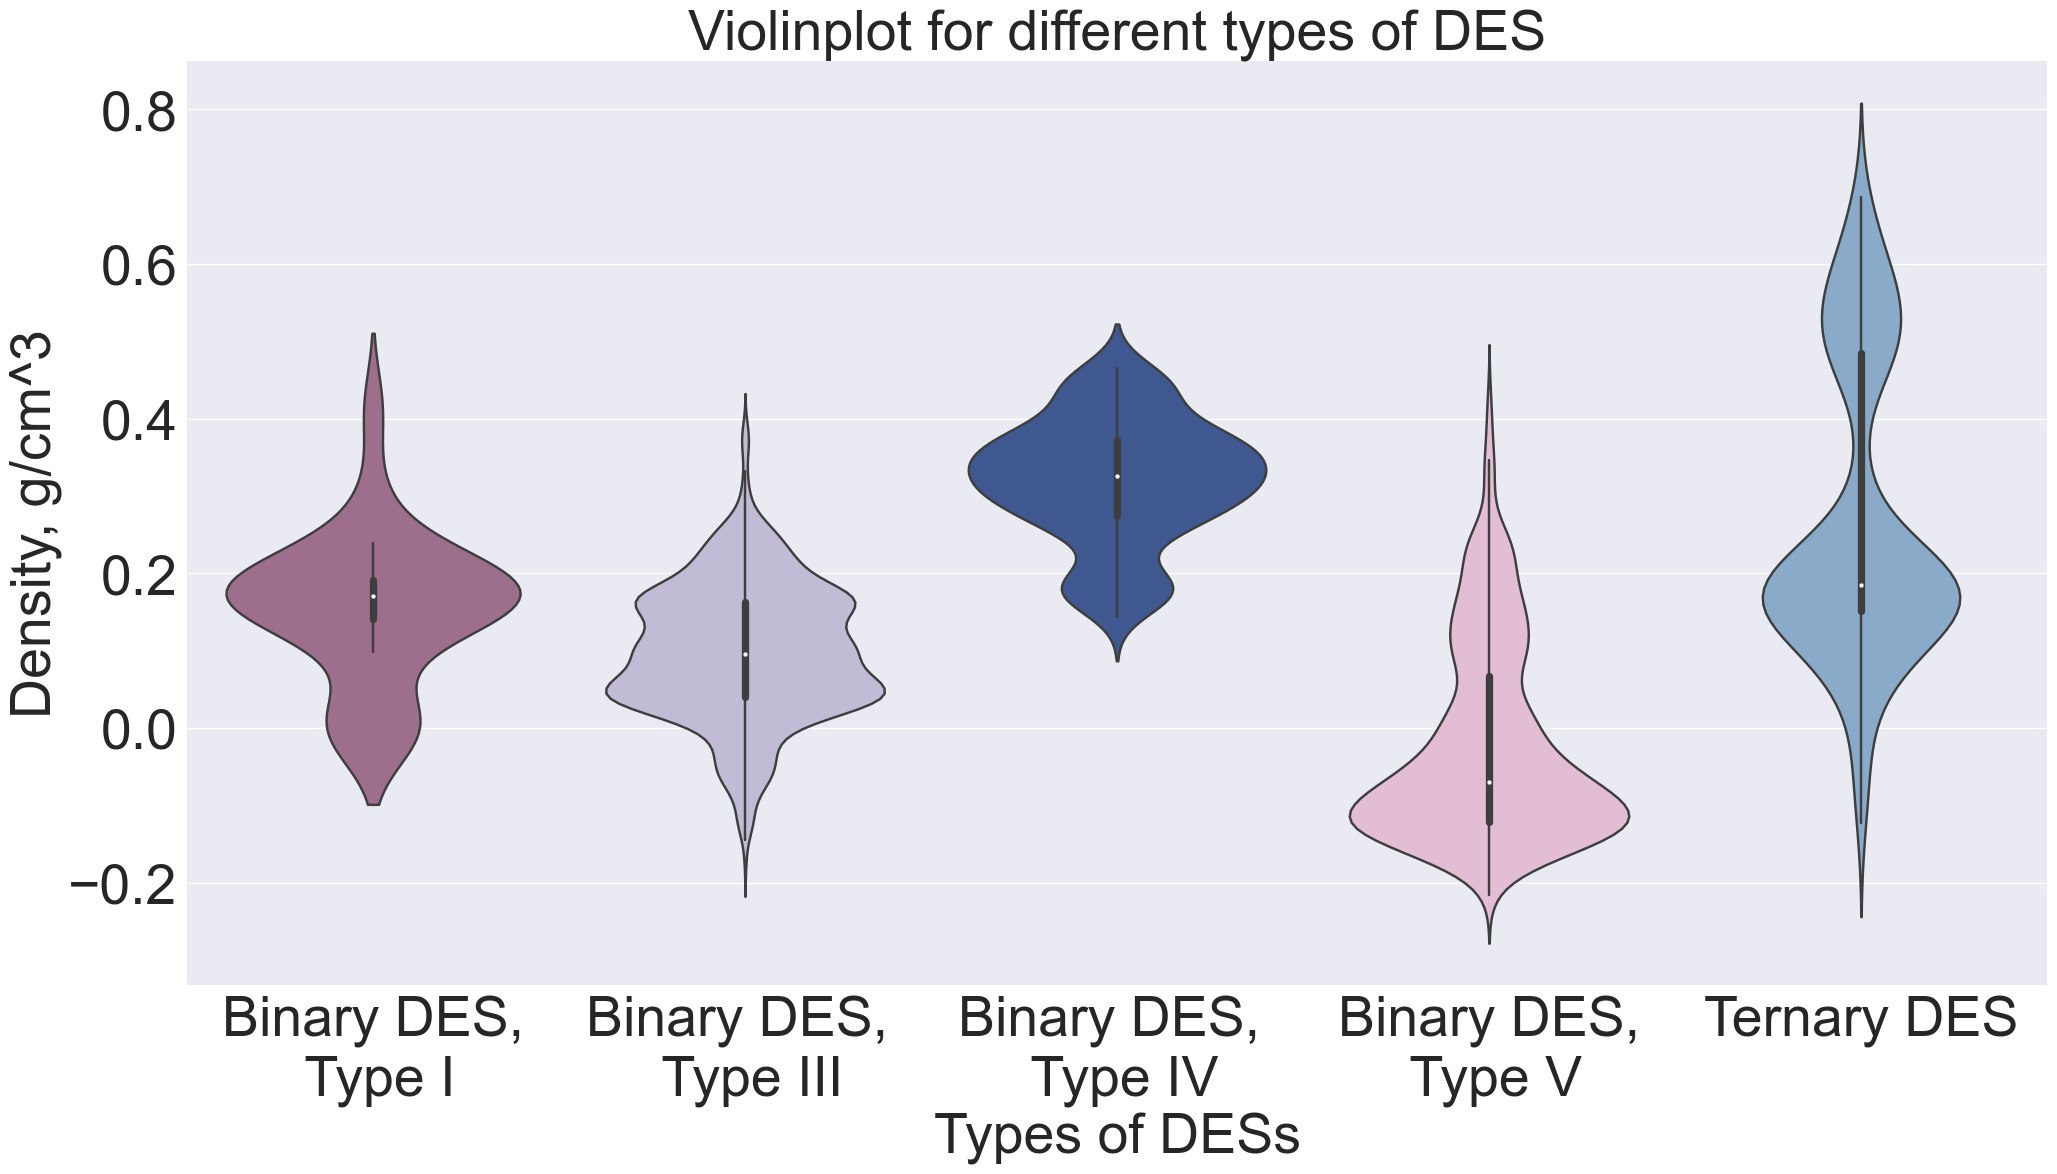

In [66]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (24, 12)) # Initialization
ax = sns.violinplot(y = np.log(density_df['Density, g/cm^3']), x = density_df['Type of DES'], palette = colors) #Building a violinplot
ax.set_xticks([0, 1,2,3,4], labels= ['Binary DES,\n Type I', 'Binary DES, \n Type III', 'Binary DES, \n Type IV', 'Binary DES,\n Type V', 'Ternary DES'])
ax.set_title('Violinplot for different types of DES', fontsize=40) #Title
ax.set_ylabel('Density, g/cm^3', fontsize=40) #Signature of the Y axis
ax.set_xlabel('Types of DESs', fontsize=40) #X-axis signature
ax.tick_params(axis='both', which='major', labelsize=40)
plt.show() 

With the help of this graph, it can be seen that the III and V types of DES are characterized by a lower density compared to other types

## 4.4. Distribution of temperature values
Let's build a histogram to see the temperature range in which our model will be able to make predictions

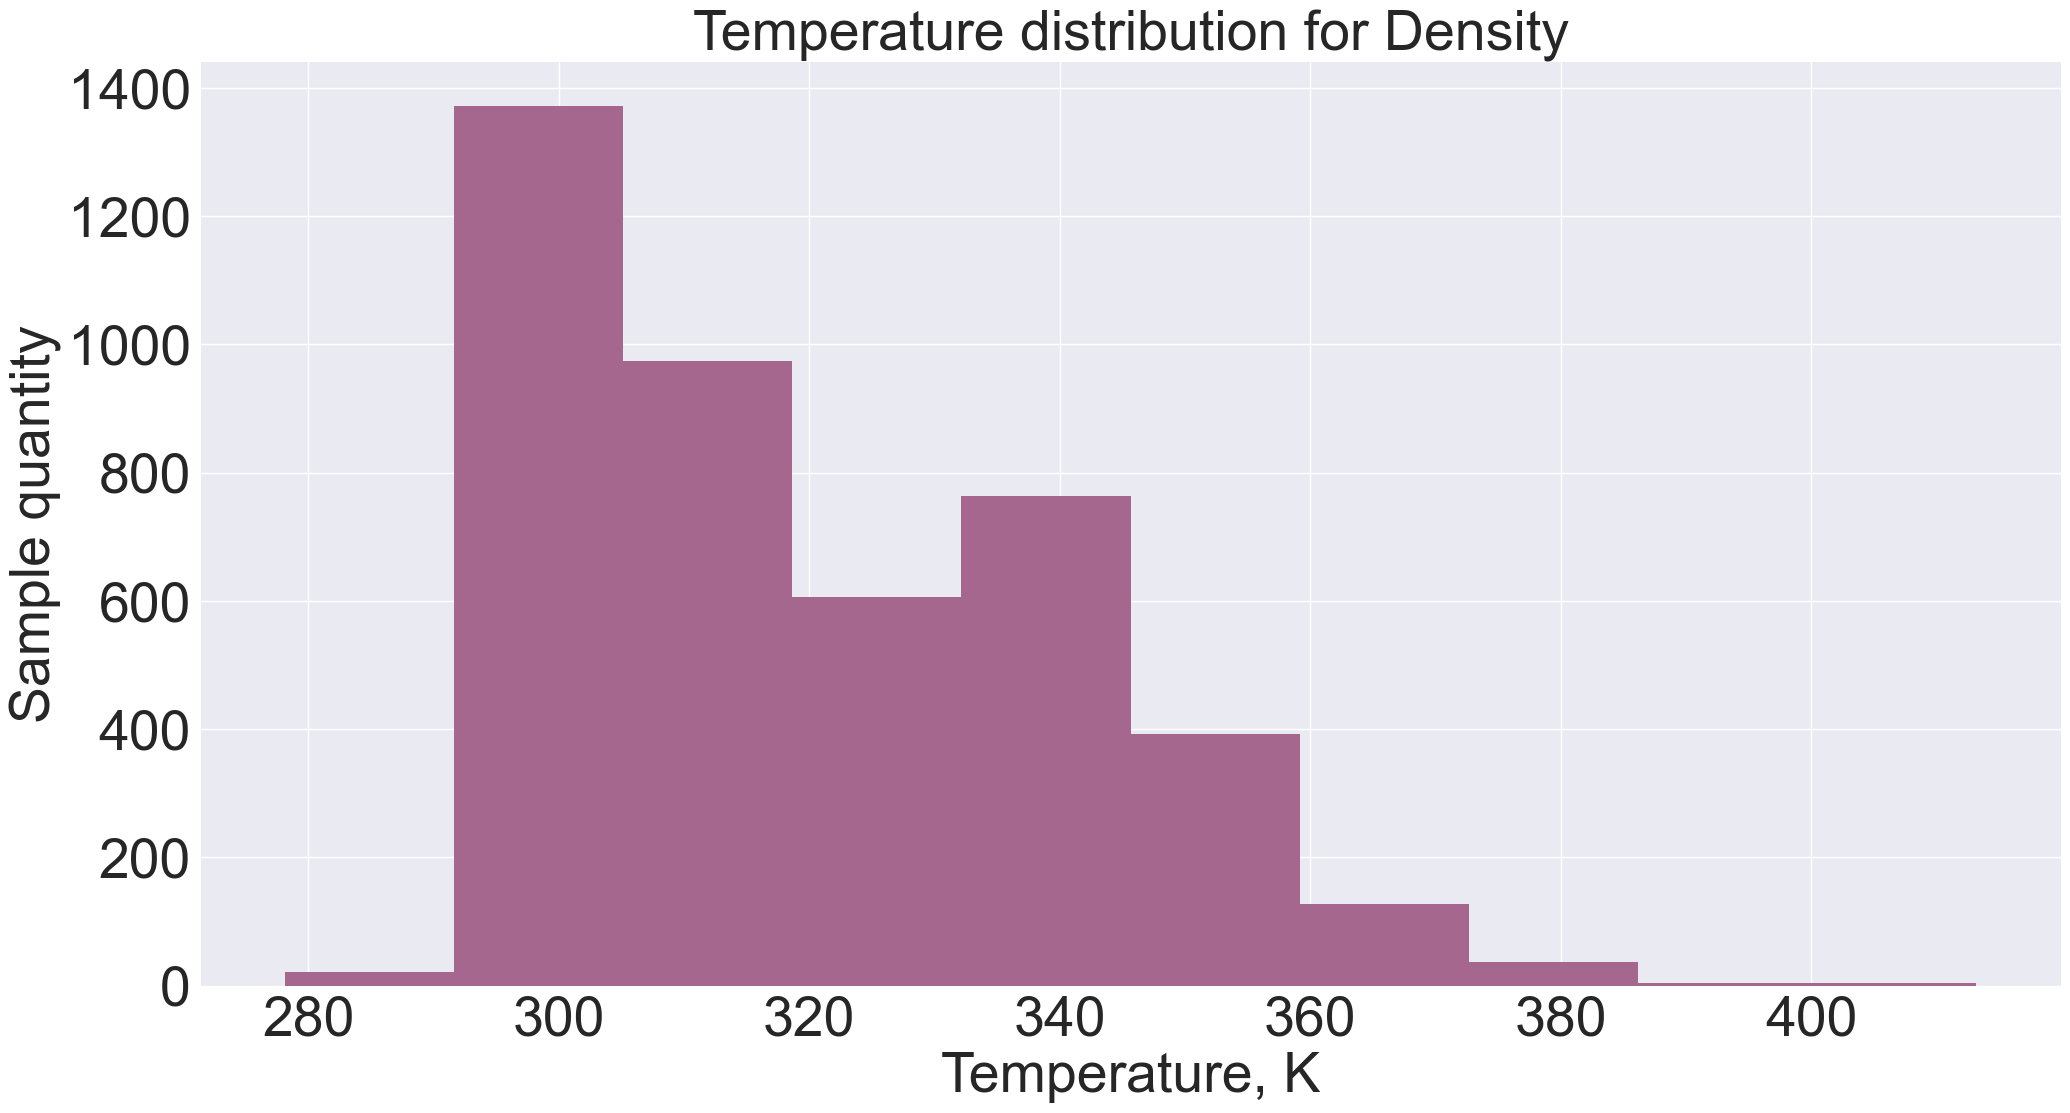

In [67]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (24, 12)) # Initialization
ax.hist(density_df['Temperature, K'], color = colors[0], bins = 10) #Building histogram
ax.set_title('Temperature distribution for Density', fontsize=40) #Title
ax.set_xlabel('Temperature, K', fontsize=40) #Signature of the X
ax.set_ylabel('Sample quantity', fontsize=40) #Signature of the Y axis
ax.tick_params(axis='both', which='major', labelsize=40)

In [68]:
#Min and max value of temperature
print(density_df['Temperature, K'].min())
print(density_df['Temperature, K'].max())

278.15
413.15


## 4.5. Statistical tests
### 4.5.1. Shapiro-Wilk

In [69]:
data = density_df['Density, g/cm^3']
stat, p = shapiro(data)
print('stat =', stat, 'p =', p)
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat = 0.9134765863418579 p = 3.0828566215145976e-44
Probably not Gaussian


### 4.5.2. Jarque-Bera test

In [70]:
print(jarque_bera(data))

SignificanceResult(statistic=3755.6938785842963, pvalue=0.0)


Both tests have a low p-value and a high stat value, so the null hypothesis is rejected, our distribution is not normal